In [1]:
import numpy as np
import scipy.optimize as op
import datetime
import emcee
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm, halfnorm
%matplotlib inline

In [2]:
# same model as forward modeling
def draw_samp(x, m, b, yerr_mu, yerr_sig, bias_mu, bias_sig, rel):
    result = []
    yerr = np.random.normal(yerr_mu, yerr_sig, size = len(x))
#     scatter = np.random.normal(scatter_mu, scatter_sig, size = len(x))
    bias = halfnorm.rvs(bias_mu, bias_sig, size = len(x))
    result = yerr - rel*bias + (m*x + b)
    return np.array(result)

In [51]:
# mixture of Gaussian model
def draw_samp_mixt(x, m, b, yerr_mu, yerr_sig, bias_mu, bias_sig, rel):
    result = []
    distributions = [
    {"type": np.random.normal, "kwargs": {"loc": yerr_mu, "scale": yerr_sig}},
    {"type": np.random.normal, "kwargs": {"loc": bias_mu, "scale": bias_sig}},
    ]
    coefficients = np.array([1.0-rel, rel])
    coefficients /= coefficients.sum()      # in case these did not add up to 1
    sample_size = len(x)

    num_distr = len(distributions)
    data = np.zeros((sample_size, num_distr))
    for idx, distr in enumerate(distributions):
        data[:, idx] = distr["type"](size=(sample_size,), **distr["kwargs"])
    random_idx = np.random.choice(np.arange(num_distr), size=(sample_size,), p=coefficients)
    sample = data[np.arange(sample_size), random_idx]
    result = sample + (m*x + b)
    return np.array(result)

In [34]:
days = np.linspace(0, 4000, num=2000)

In [52]:
sample = draw_samp(days, 0.0, .67, 0.0, .1, 0.0, .25, .6)
print(sample)
sample2 = draw_samp_mixt(days, 0.0, .67, 0.0, .1, 0.0, .2, .6)
print(sample2)

[ 0.5848664   0.44379889  0.66196034 ...,  0.66339678  0.71319078
  0.28003927]
[ 0.77471528  0.67477239  0.59685141 ...,  0.50584191  0.83553575
  0.65631723]


In [53]:
def lnlike(theta, x, y):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, a2, L = theta
    BN_lim = 200
    #number in variable name is the gaussian j
    m = 0
    y_mod1 = m*x + b - delty1
    y_mod2 = m*x + b - delty2
    chisq1 = (1/sigsq1) * np.matmul(y-y_mod1, (y-y_mod1).T)
    chisq2 = (1/sigsq2) * np.matmul(y-y_mod2, (y-y_mod2).T)
    if chisq1 > BN_lim:
        chisq1 = BN_lim
    if chisq2 > BN_lim:
        chisq2 = BN_lim
    H = [np.exp(-chisq1/2), np.exp(-chisq2/2)]

    beta1 = -2.0*np.log(a1/np.sqrt(2*np.pi*sigsq1))
    beta2 = -2.0*np.log(a2/np.sqrt(2*np.pi*sigsq2))
    M = []
    for i in range(len(days)):
        if i == 0:
            temp_y = y[i+1:]
            temp_x = x[i+1:]
        else:
            temp_y = np.concatenate((y[:i],y[i+1:]))
            temp_x = np.concatenate((x[:i],x[i+1:]))
        temp_y_mod1 = m*temp_x + b - delty1
        temp_y_mod2 = m*temp_x + b - delty2
        minor_chisq1 = sigsq1 * np.matmul(temp_y-temp_y_mod1, (temp_y-temp_y_mod1).T)
        minor_chisq2 = sigsq2 * np.matmul(temp_y-temp_y_mod2, (temp_y-temp_y_mod2).T)
        M.append([np.exp(-.5*(beta1 - minor_chisq1)), np.exp(-.5*(beta2 - minor_chisq2))])
    
    MxH = np.matmul(np.matrix(M), np.matrix(H).T)
    
    #calc optimal lambda
    full_a = np.array([[a1, a2],]*len(x))
    full_H = np.array([H,]*len(x))
    N = np.multiply(np.divide(M,full_a),full_H)
    NxH = np.matmul(np.matrix(N), np.matrix(H).T)
    lambda_star = -0.5*np.sum(np.divide(NxH,MxH))
    print(lambda_star)
    
    return np.log(MxH).sum() + L*(a1+a2-1)

In [54]:
def lnprior(theta):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, a2, L = theta
    if 0.0 < b < 1.0 and delty2 > 0 and 0.0 < a1 < 1.0 and 0.0 < a2 < 1.0 and sigsq1 > 0.0 and sigsq2 > 0.0 and L > 0.0:
#         pri_m = norm.logpdf(m, 0.0, .01)
        pri_delty1 = norm.logpdf(delty1, 0.0, 0.5)
        pri_delty2 = norm.logpdf(delty2, 0.3, 0.5)
        pri_sigsq1 = norm.logpdf(sigsq1, .01, .01)
        pri_sigsq2 = norm.logpdf(sigsq2, .04, .01)
        pri_a1 = norm.logpdf(a1, 0.5, .5/3.0)
        pri_a2 = norm.logpdf(a2, 0.5, .5/3.0)
        pri_L = norm.logpdf(L, -2.04976186279e-41, 10**-5)
        return pri_delty1 + pri_delty2 + pri_sigsq1 + pri_sigsq2 + pri_a1 + pri_a2 + pri_L
    return -np.inf

In [55]:
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [56]:
ndim, nwalkers = 9, 200
pos = [np.random.randn(ndim)*1e-4*[0.00001, .6, 0.0, 0.3, .01, .04, .5, .5, 1.0] for i in range(nwalkers)]

In [59]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, sample2), threads=4, a=2.0)

-5.18443153394e-37
-3.18155688335e-37
-5.20144359286e-37
-2.82208945081e-36
-4.99416731197e-37
-4.28278991626e-37
-1.44429230612e-37
-6.41747395655e-37
-2.88093536277e-37
-1.54522866278e-37
-6.43509073151e-37
-2.99135913594e-36
-1.12949198735e-37
-1.143341871e-36
-1.06729787577e-37
-3.81737944437e-37
-1.11530650679e-36
-7.71628493012e-38
-1.10262790267e-36
-1.89255669053e-37
-1.14139154181e-36
-6.95799303445e-37
-2.8062907733e-36
-6.10884990368e-37
-1.38533890149e-37
-1.15186660727e-36
-1.88057285175e-37
-2.24602541673e-36
-8.58085447865e-37
-1.09638090142e-36
-2.1947357028e-37
-7.75187048321e-37
-1.77674678275e-37
-1.32622095421e-36
-6.88864273943e-37
-3.44957359659e-37
-1.40427458056e-36
-9.50190075804e-37
-1.23617429224e-37
-4.56635194015e-36
-9.23515712254e-37
-7.84401530658e-37
-1.10399480224e-36
-7.26062257005e-37
-3.0278253284e-36
-1.7600822885e-36
-8.08369899139e-37
-2.98297259591e-37
-1.09957209376e-35
-7.46791742666e-37
-1.30247501376e-36
-1.73284226044e-36
-8.3589069844e-37


-3.20902667845e-37
-2.26785435259e-37
-4.65091007792e-38
-1.08930746145e-37
-1.23211401758e-37
-9.22222994686e-37
-1.0258873996e-37
-7.44694868942e-37
-2.94578200658e-37
-7.90885051382e-38
-8.06618281178e-38
-5.70915347242e-37
-3.96702153996e-38
-8.11052791874e-37
-8.17818187853e-37
-7.04632766258e-38
-8.2725455716e-38
-4.38578986506e-38
-2.56791679515e-36
-4.15577229791e-37
-6.6000388112e-38
-1.9832117082e-37
-1.00440283843e-37
-2.37966158832e-37
-1.46548840463e-37
-5.89758870241e-37
-7.89115853445e-38
-7.71498219958e-38
-1.99366787368e-37
-1.51499626024e-37
-1.51000109386e-37
-2.67881146411e-37
-3.01966051668e-38
-1.27390887926e-37
-3.21448807259e-37
-3.16721709181e-37
-9.86982340227e-38
-6.50536155655e-38
-8.28023244744e-38
-1.50091767811e-37
-2.45306585921e-37
-1.80174871777e-37
-3.9899024935e-37
-9.40112387614e-38
-1.95558841493e-37
-1.19509342505e-37
-6.61995504402e-38
-3.65736317362e-38
-4.43968309033e-37
-1.92461971378e-37
-8.12499119061e-38
-4.7074217891e-37
-7.64805744535e-37

-2.76992450236e-37
-3.40337994696e-37
-3.67182935956e-37
-5.03014560256e-38
-2.49164488424e-37
-1.07726532068e-37
-2.20023424424e-37
-1.40856979045e-36
-8.33769746056e-39
-3.30653600804e-38
-3.5524529992e-38
-1.25684364391e-37
-7.47357148854e-38
-1.27956676193e-37
-1.44217410375e-37
-2.02772826495e-38
-1.26079760254e-37
-7.40814685218e-38
-1.52430489349e-37
-4.96896532498e-37
-5.03742636084e-38
-1.82225850951e-37
-1.75769362926e-37
-1.07915026966e-37
-9.62945026665e-37
-6.35799423473e-38
-5.61566999463e-38
-2.9891235503e-38
-8.0662316629e-38
-1.46702578525e-37
-2.04205057084e-37
-1.43907255741e-37
-1.58447547951e-37
-9.90348264265e-38
-4.16283334361e-38
-4.40449116371e-37
-6.17840675073e-37
-6.06689597228e-38
-1.4453417045e-38
-1.00134888834e-37
-5.04754056201e-38
-1.72189320249e-37
-2.27027529428e-38
-5.28769254629e-37
-1.0677299972e-37
-4.08666295466e-38
-1.1718261014e-37
-2.30665132163e-37
-1.20408262997e-37
-5.53729437615e-38
-1.42883999096e-37
-1.150399021e-37
-1.34717625018e-37
-

-8.08783664563e-38
-1.02220847987e-37
-3.36577864634e-37
-3.7011007194e-37
-9.915777761e-38
-4.9249977505e-38
-1.94330611414e-37
-8.11719287538e-38
-1.54171668142e-37
-1.9684876899e-38
-4.10840788603e-38
-3.75245320035e-38
-2.13818693023e-38
-9.97598652276e-38
-2.66680918087e-37
-7.75757513845e-38
-8.03648974875e-38
-5.31533305585e-38
-4.81868789455e-37
-6.45722943751e-38
-6.55388781057e-38
-1.27260210048e-37
-5.45720710057e-38
-1.56072362721e-37
-1.30403819386e-37
-1.84298257204e-38
-1.27713309886e-37
-2.69126339549e-37
-1.15785538738e-37
-2.44907278505e-37
-1.01569071012e-38
-2.70753414039e-37
-7.19290761765e-38
-6.40644844591e-38
-7.82276137489e-38
-3.4148727484e-37
-2.7947668578e-38
-2.11036381953e-38
-1.30429252273e-37
-1.20322983289e-37
-1.16028274578e-37
-1.49155302729e-37
-2.33211161538e-38
-7.08118952604e-38
-4.79869449577e-37
-5.76943113635e-38
-5.81464166329e-37
-8.02112352359e-38
-1.60800122066e-38
-1.85599759936e-37
-1.70153515099e-37
-1.00557707576e-37
-2.5665086635e-37
-

-2.72016759781e-38
-8.53315429573e-38
-3.33392302095e-37
-1.08810947856e-38
-5.47177075671e-38
-4.05476387194e-38
-2.98830481709e-37
-1.89962202791e-37
-3.7447105514e-38
-2.14549070921e-37
-2.63499397095e-38
-1.69079221034e-37
-8.14608026366e-38
-7.91405961189e-39
-1.31034196397e-37
-2.09257295161e-37
-4.64594680985e-37
-2.33669831913e-38
-5.51117203814e-38
-1.69902861152e-37
-4.91849156869e-38
-5.21241151439e-37
-1.69078367546e-37
-1.09265151614e-37
-2.06406501997e-38
-8.80576769127e-38
-6.44218582675e-38
-1.5192553749e-37
-2.08135360667e-37
-5.05407980243e-37
-3.49625454215e-37
-1.63716971154e-38
-9.45890158384e-38
-9.15259615182e-38
-2.3679676822e-38
-2.55545450741e-37
-5.4582119479e-38
-1.04606944601e-37
-5.05968608105e-38
-2.09990619907e-37
-5.00312338343e-37
-9.84417931014e-38
-9.53341423034e-38
-2.2669285812e-38
-1.61077590512e-38
-3.68145516615e-38
-7.99762035339e-38
-1.98388829958e-37
-4.08764263472e-38
-8.53606749484e-38
-4.87094694961e-38
-2.70660765988e-37
-7.59460967696e-3

-6.63149136759e-38
-3.12460522094e-38
-1.80843874569e-38
-4.50040698105e-38
-2.93365591178e-38
-3.9720064757e-37
-2.60180324951e-38
-4.70350367382e-38
-7.25472149841e-38
-4.13292663063e-38
-3.41554721595e-37
-1.90078850024e-38
-2.17769794039e-37
-2.33285762917e-38
-1.09061718708e-37
-1.05013562031e-37
-1.67337503722e-37
-2.24212563911e-37
-1.32287509831e-37
-1.2116712443e-38
-1.04643514204e-38
-3.03039516078e-37
-2.10269207599e-38
-6.60553694296e-38
-1.52241719771e-37
-1.26510078376e-37
-3.98095601772e-38
-1.9784939706e-38
-1.87698237743e-38
-3.60659947171e-38
-1.18013670503e-37
-6.38162996532e-39
-1.48426364267e-37
-2.75442783547e-38
-8.33277640735e-38
-6.63387431426e-38
-9.79199777719e-39
-2.7314341554e-38
-2.19210039445e-38
-1.0473418642e-37
-2.29523360125e-38
-1.58973436492e-38
-3.0362599676e-38
-2.41698078114e-38
-6.12793306504e-38
-8.87788524225e-38
-2.03665700839e-38
-7.83409816472e-38
-4.37452899753e-38
-2.20975729001e-37
-3.54677284168e-38
-8.56174878299e-38
-1.64059560888e-37

-1.21920345139e-37
-5.38739025443e-38
-1.18684435007e-37
-1.23166245614e-38
-6.7898228626e-38
-2.51868979699e-38
-1.36398709222e-39
-2.63771445302e-37
-4.24351054891e-38
-9.63874290238e-40
-8.80462752e-38
-2.67749851854e-38
-2.80884858173e-38
-1.02455596392e-38
-4.96091651401e-38
-6.45839936019e-39
-8.98910160685e-38
-9.80720478685e-38
-1.128285774e-38
-1.61566536059e-37
-1.43449081041e-37
-1.23054622306e-38
-1.76058730141e-38
-6.61792828949e-38
-3.34505315858e-38
-5.47455435168e-38
-9.79254501916e-38
-1.66872637028e-38
-7.23914315894e-39
-4.86232907546e-38
-5.0143760267e-38
-1.60475790065e-37
-7.05634215658e-38
-2.62022510766e-38
-2.21576661119e-38
-3.70444423675e-38
-9.73291751619e-38
-1.17293348695e-38
-2.88324891427e-37
-8.11709942152e-38
-4.69351870004e-38
-2.7883138516e-38
-1.12971093748e-39
-8.49517692451e-38
-1.16327497124e-38
-3.05998706052e-38
-1.29829323481e-37
-6.3366633353e-38
-1.0011230981e-37
-2.8435395687e-38
-2.16692579993e-37
-1.71867600735e-37
-2.73933894292e-38
-3.8

-1.20841903517e-38
-1.7730968426e-37
-6.56037785476e-38
-4.0258629723e-39
-4.75599499382e-39
-6.20146102622e-39
-2.14128136716e-38
-3.45708281475e-38
-1.09994475779e-37
-8.33660383134e-38
-9.92962181104e-38
-1.89094726382e-38
-2.76559962062e-39
-4.76516809502e-38
-2.00357530056e-37
-3.92409327157e-39
-5.74237641186e-38
-2.52002584861e-38
-9.03985208074e-39
-3.30974499786e-38
-3.00432678785e-38
-4.77281916338e-39
-6.76017832527e-38
-2.02756080458e-38
-2.28347087842e-38
-6.97690993755e-39
-1.19792120779e-38
-2.58614901543e-38
-1.1963894464e-38
-5.34269169312e-38
-1.29152425373e-38
-1.60702714636e-39
-1.08114967324e-38
-2.03998483585e-38
-5.35080028428e-39
-5.11363024031e-37
-2.67204968475e-38
-4.51742647102e-38
-2.92933911303e-38
-3.49720823446e-38
-1.70644780096e-38
-8.60841911444e-38
-1.68376738611e-37
-2.23315121695e-38
-8.88342335505e-38
-1.50325751426e-38
-3.59951086412e-39
-3.78708518053e-38
-2.00758592162e-38
-2.73714582007e-39
-3.29082209794e-37
-1.83080469697e-39
-2.43874914742e

-1.40544947927e-37
-2.74355710048e-39
-8.75717492603e-39
-8.41576479357e-38
-7.29024802729e-40
-2.72982305912e-38
-3.1994984515e-38
-7.23761613593e-39
-4.19208026992e-39
-1.77636431945e-38
-8.87652340798e-39
-3.65111280877e-38
-9.44569915355e-38
-5.03437756632e-39
-4.92076067111e-39
-1.57787461082e-39
-2.40542622247e-38
-6.14063631791e-38
-1.2321838371e-38
-1.12035438709e-39
-9.54716920788e-38
-2.09447030521e-38
-1.0044919032e-37
-3.89334324686e-38
-4.35456409597e-38
-2.29296989646e-39
-2.7460420239e-39
-5.19692782101e-39
-7.69741511001e-40
-6.24942524236e-39
-7.36393528133e-38
-3.52538531314e-39
-4.97472713053e-40
-3.70115793562e-39
-1.98545039349e-39
-1.21417339577e-39
-2.10059633673e-38
-9.59365384101e-39
-2.86152521815e-38
-8.10001952212e-39
-5.27902310549e-39
-6.25572880714e-39
-1.78451245291e-38
-2.08771239586e-39
-7.0862725864e-38
-2.86348209092e-38
-4.8144443966e-39
-2.15727088447e-38
-5.61343786153e-39
-2.72883453381e-38
-4.06334207096e-38
-3.52450514704e-39
-2.33830662765e-38

-3.12972234625e-39
-1.25689502008e-38
-5.67154270194e-39
-3.00579234935e-38
-1.16844243582e-39
-5.65803064003e-39
-1.30576965475e-38
-3.20572391473e-39
-4.00112140639e-39
-1.38933250393e-38
-8.90321867922e-39
-1.94410893821e-38
-5.6510788479e-38
-1.52871297049e-38
-1.11560764447e-39
-3.03121116531e-39
-3.351017851e-38
-3.13693346772e-39
-7.87440488776e-39
-2.26335360861e-39
-1.77440428966e-39
-1.7228674518e-38
-4.94934746386e-39
-6.92456069684e-39
-1.93785200073e-38
-5.59225920138e-39
-2.52650953973e-40
-2.87347257409e-39
-3.53575636231e-39
-5.46392224663e-39
-6.64186529864e-39
-6.2656074742e-39
-1.56924708346e-39
-1.87432506328e-38
-1.56314553566e-39
-3.64016211393e-39
-2.61009326776e-38
-2.34977981497e-38
-1.55626582734e-39
-1.83463710946e-39
-8.4844262212e-40
-2.34622040037e-39
-1.14974400708e-38
-4.55954081081e-39
-3.44908978741e-39
-1.10700151678e-37
-7.00150704641e-39
-5.83842978416e-39
-1.48140311663e-38
-1.648127644e-39
-8.09416084823e-39
-8.56190012907e-40
-4.03604206e-39
-1.4

-2.52457916604e-38
-1.98215207299e-39
-5.95514622974e-39
-6.36239687128e-40
-2.16259605398e-39
-1.89170933936e-38
-9.36413861419e-40
-2.97393603093e-39
-4.01128889931e-39
-6.54163978643e-40
-8.2320428336e-39
-7.54901811724e-39
-4.85650131008e-39
-1.10375585884e-39
-6.69910547881e-40
-4.06458213128e-39
-7.49549096162e-39
-1.97309143045e-38
-5.98664157938e-39
-2.01172072746e-39
-4.03306373633e-40
-5.69058857682e-39
-2.32014012813e-39
-4.76227211786e-37
-1.89546548812e-38
-1.06761615451e-37
-1.08537961207e-39
-2.3802542157e-38
-4.36909998497e-39
-6.48284278172e-39
-1.7751128273e-38
-1.51855256465e-39
-1.5319550385e-38
-3.3606870577e-39
-8.8742043344e-39
-3.87165403851e-39
-1.28682982249e-39
-2.39158891302e-38
-1.19285310902e-38
-7.62987142128e-39
-1.35897165092e-39
-8.35348070447e-39
-3.48984779576e-39
-1.74970124264e-39
-8.14589115996e-40
-1.5992701172e-38
-3.0107827128e-39
-8.02146994134e-39
-8.45523436997e-39
-1.0204422605e-38
-7.21866316741e-39
-1.4984066296e-38
-4.65018058259e-39
-3.

-5.44713170698e-40
-7.92629427829e-39
-7.56179251992e-39
-6.51244316859e-39
-4.04442249382e-39
-1.24277352229e-38
-7.47949974056e-38
-5.36403027648e-39
-1.0413945107e-38
-2.84370108547e-39
-2.37108182799e-38
-6.04051107357e-39
-1.84849947876e-37
-1.33022907502e-39
-7.80824007723e-39
-6.36912006102e-40
-2.88012529494e-39
-1.11018927388e-39
-1.13853133863e-39
-5.10889866747e-40
-1.42047764693e-40
-1.09854042864e-40
-7.61826411845e-40
-7.63993769502e-41
-1.31733077103e-39
-2.7629751154e-39
-5.68513937978e-39
-6.57866408077e-40
-2.61152854377e-39
-6.22495127584e-40
-1.57895172069e-39
-4.68222387404e-37
-9.64768629688e-39
-7.64365690532e-39
-7.17624322646e-39
-6.21375211727e-39
-8.94001010917e-39
-3.95158036698e-40
-2.37047543324e-39
-4.16047193994e-39
-6.35523213838e-39
-1.06106993647e-39
-1.97035893667e-38
-2.11562092357e-39
-3.46774952544e-39
-4.87044831583e-39
-1.32084536937e-40
-3.27558082469e-39
-1.21500294939e-39
-1.52051799106e-39
-7.86196597982e-40
-1.23166169494e-39
-1.97530245237

-4.8245952766e-39
-2.04921790841e-39
-3.72989610551e-40
-6.41048602451e-40
-2.56976275747e-39
-1.15280794238e-39
-2.6021078161e-39
-5.94278990933e-41
-3.09515243443e-39
-1.10452899626e-40
-4.05719338539e-39
-8.90443825073e-40
-1.15244837314e-40
-5.58964782112e-40
-3.1391624302e-39
-5.47595868714e-40
-8.0003465582e-40
-9.77590938576e-39
-6.20363162191e-40
-3.97591773616e-39
-1.55349455638e-39
-5.88001927182e-40
-2.92680174259e-39
-1.98545247188e-38
-1.01269871978e-39
-7.28873152899e-40
-2.69098919806e-39
-4.36044589423e-40
-5.11437109302e-39
-3.16450542693e-39
-3.76233015372e-39
-3.41007797437e-40
-1.55754992325e-39
-3.54896507658e-40
-1.62262975817e-40
-3.94213078664e-40
-1.89624230825e-39
-2.40553598784e-39
-7.73535976388e-40
-4.23895739236e-40
-6.55868874209e-40
-5.7309736263e-40
-9.13232636845e-40
-2.95449392563e-39
-5.51704347615e-40
-1.24385944458e-38
-7.49179280767e-40
-7.98854053095e-40
-5.02938887659e-40
-1.74861927564e-39
-5.24733002915e-39
-2.61595547531e-40
-1.14390291722e-3

-4.47637876594e-40
-2.60508923062e-39
-5.99444141497e-41
-9.96082269162e-40
-9.00841771604e-41
-1.07800855099e-39
-7.69829600577e-40
-8.10988201389e-40
-5.11965202233e-40
-1.11414943548e-39
-3.66616730185e-40
-1.14555944605e-39
-3.34004771998e-39
-3.33649070198e-40
-8.31824169771e-40
-6.01949185454e-40
-2.26863519205e-39
-5.24115513124e-40
-2.27186968291e-40
-1.83598900899e-39
-2.46222048813e-39
-1.76576061028e-39
-1.37068288354e-40
-8.00388261741e-40
-4.37514278652e-40
-9.21701422459e-40
-6.27906683207e-40
-3.0922054759e-40
-2.05532919867e-40
-2.84073976729e-39
-3.80526655936e-40
-4.05236557234e-40
-4.94341422038e-40
-7.10960710356e-40
-1.25397396629e-39
-2.46388605999e-39
-5.86007960513e-40
-1.21483415293e-39
-9.52900826443e-39
-8.05202831556e-40
-2.33425056475e-40
-3.85279180845e-40
-1.35354005535e-40
-7.92763966586e-40
-1.82001638805e-40
-1.72700768595e-39
-8.46375749475e-40
-1.91410626247e-38
-4.40119701963e-40
-2.01791279252e-39
-8.06243969698e-40
-1.31298547997e-39
-1.6249397703

-2.4519958833e-40
-1.05556718055e-39
-6.63869125492e-40
-5.81214194504e-40
-3.19966526698e-39
-4.98275413365e-40
-1.00345649236e-40
-4.06344345726e-39
-3.73488621853e-40
-1.6648832029e-39
-9.16126693136e-40
-7.22403029451e-40
-3.57291790089e-40
-3.07596796321e-40
-1.82377751651e-39
-4.3342525031e-40
-1.30881612255e-40
-1.26910690324e-40
-3.40545257277e-40
-4.1201938063e-39
-1.70632904599e-40
-3.0170312884e-40
-5.56474730467e-40
-1.77217861734e-40
-4.08206807188e-40
-2.09126893708e-40
-3.2585210154e-40
-5.48085395491e-40
-2.5921271498e-40
-1.62005485049e-39
-1.97678141168e-40
-3.48713159648e-40
-5.4370939331e-40
-2.20790426833e-40
-2.92017052776e-40
-2.50960786316e-39
-1.67178007939e-40
-8.19760603201e-40
-1.35129901915e-39
-1.27404805859e-40
-1.86902849874e-40
-2.88284080167e-40
-9.333331629e-41
-1.23330769014e-39
-2.04897504387e-40
-7.3673541592e-40
-5.28331893571e-40
-1.09880747617e-39
-8.00450681813e-40
-3.45022618934e-40
-2.14713283626e-40
-1.2343470724e-40
-7.43355829658e-40
-2.05

-4.44080893346e-40
-3.45272067222e-39
-4.57339301327e-40
-3.31336956709e-40
-1.23555668878e-40
-6.08104709891e-40
-3.10463942142e-40
-5.76444755141e-39
-2.43046072586e-40
-2.02027501583e-40
-4.91169886946e-40
-1.66385474214e-40
-1.59606888542e-39
-3.07612102271e-40
-5.46330062776e-40
-1.21503813503e-39
-4.3428461322e-40
-6.04613502988e-41
-5.50520732606e-40
-7.9444384549e-40
-6.94874028795e-40
-2.07460905603e-40
-3.29338405667e-40
-1.94002903582e-40
-1.10709468765e-40
-2.66816762426e-39
-1.18379928326e-40
-4.11891825652e-40
-4.87558342563e-40
-3.57932605638e-40
-5.88297164258e-40
-3.68741784797e-40
-1.86285285198e-40
-1.05311409294e-40
-3.66029605215e-40
-3.451374622e-40
-4.76454009657e-40
-1.29373528674e-40
-2.11763612001e-40
-1.64915222111e-40
-1.63313629777e-40
-3.40707970823e-40
-3.29603339183e-40
-5.33889190916e-40
-4.01862225748e-40
-8.6211325935e-41
-1.16967246718e-40
-2.09204247396e-40
-2.29833980832e-40
-1.67918525998e-39
-2.34490271519e-40
-9.0282782923e-41
-1.02543251051e-39

-3.78103040605e-40
-1.35530860531e-40
-4.08862991638e-40
-4.00417938957e-40
-8.76728917385e-40
-5.44210384901e-40
-3.03551714334e-40
-4.23121688989e-40
-2.37375820889e-40
-2.70906440049e-40
-3.43008331348e-40
-4.79016618229e-40
-2.78550182348e-40
-2.8902825899e-40
-3.28388430239e-40
-2.65698353504e-40
-1.35218042853e-40
-4.68580656581e-40
-2.90499354464e-40
-2.18115426546e-40
-4.06825454913e-40
-8.68352789904e-40
-1.32354010123e-40
-9.4852710982e-41
-2.35050847014e-40
-8.57718872866e-40
-5.35899703235e-40
-5.56100387036e-40
-3.54289370934e-40
-2.16709560807e-40
-4.8513519916e-40
-5.92941549748e-40
-1.00334345035e-40
-5.41166974748e-40
-3.44700693919e-40
-4.82572465222e-40
-9.90365657748e-40
-1.15559876014e-39
-4.00474390882e-40
-1.66691222902e-40
-3.33242197642e-40
-4.99267652178e-40
-2.55932981564e-40
-2.79050459649e-40
-2.27762081631e-40
-1.93458864194e-40
-8.09337076282e-41
-1.82524308265e-40
-6.07650410734e-41
-2.30871807323e-40
-3.33987859471e-40
-2.0725317199e-40
-5.55156289028e-

-1.88131245736e-40
-4.48941714798e-40
-2.90897700534e-40
-2.0244027592e-40
-2.579646306e-40
-1.70593466994e-40
-1.87526856932e-40
-1.00279804768e-39
-1.09854993079e-40
-1.58488983345e-40
-1.05702169419e-40
-5.76970516841e-41
-2.01495200076e-40
-1.16226018229e-40
-1.16590991769e-40
-3.05931679838e-40
-5.26670546903e-41
-2.5424330265e-40
-4.71069378426e-40
-8.07783093688e-40
-1.26616827832e-40
-2.55885779583e-40
-1.25743455267e-40
-1.56135760679e-40
-1.16191640401e-40
-1.00514716229e-40
-3.0666015292e-40
-1.9872672451e-40
-1.28608441624e-40
-1.77521666524e-40
-3.59088008567e-40
-2.37927311719e-40
-5.25658800519e-40
-3.31685724527e-40
-2.34371134322e-40
-2.775876885e-40
-4.7923071744e-40
-1.92762154496e-40
-4.09760674269e-40
-2.4057475363e-40
-3.07123332716e-40
-3.98101834152e-40
-1.85927146088e-40
-2.81080015049e-40
-1.3861118697e-40
-1.15950024352e-40
-2.79051115569e-40
-3.03478625163e-40
-2.90196698292e-40
-1.5718785735e-40
-1.09819245239e-40
-3.32423543193e-40
-1.28055263269e-40
-2.12

-2.61077868132e-40
-7.9427423516e-40
-1.05176017757e-40
-1.46575290934e-40
-8.729917628e-41
-1.15739296778e-40
-1.44159028252e-40
-2.14240143318e-40
-9.45542359587e-41
-1.54749890146e-40
-1.85461894032e-40
-8.65133850618e-41
-3.43049390572e-40
-1.40348183427e-40
-2.4943204915e-40
-1.94432894427e-40
-2.86548473228e-40
-2.38180108968e-40
-6.67079854517e-41
-2.52771468411e-40
-7.27744308457e-40
-3.87977556956e-40
-3.44449156287e-40
-1.3555726778e-40
-2.33820196667e-40
-3.17873457991e-40
-2.33343962175e-40
-1.53080778669e-40
-1.74839318114e-40
-2.08745847652e-40
-2.35523164457e-39
-2.43715800119e-40
-2.35633830618e-40
-9.20528702418e-41
-3.6580180149e-40
-1.90404318034e-40
-2.16740675343e-40
-1.21951615359e-40
-3.54933392097e-40
-1.21684209115e-40
-2.24643198281e-40
-1.27235218846e-40
-2.22143521834e-40
-1.88421477322e-40
-5.12583088633e-40
-9.17919809245e-41
-2.04033297641e-40
-1.15167260924e-40
-4.04806521377e-40
-1.49598038892e-39
-1.42770184294e-40
-3.66768300443e-40
-2.55913047505e-40

-8.72288981418e-41
-3.1752577164e-40
-1.86240296485e-40
-1.73103655087e-40
-9.62319820535e-41
-2.89136279503e-40
-1.12951220947e-40
-3.94598721016e-40
-7.83325169818e-41
-3.66881025574e-40
-1.01610328991e-40
-3.01990763543e-40
-6.03362590375e-40
-1.82446181793e-40
-1.07582507198e-40
-1.51686248367e-40
-2.21955135054e-40
-2.03461667352e-40
-7.73642808338e-41
-1.93546985345e-40
-2.38934239173e-40
-1.4848237257e-40
-1.01112289753e-40
-4.24036194878e-40
-2.14301710174e-40
-9.24146022397e-41
-1.82930541572e-40
-2.64186666039e-40
-2.46592743642e-40
-5.74162109428e-41
-2.29707772128e-40
-2.82934597963e-40
-1.54508565656e-40
-1.00417881753e-40
-1.40496874278e-40
-1.64269932625e-40
-1.53000366424e-40
-9.56326014368e-41
-2.71704534524e-40
-3.31156842206e-40
-3.8271882582e-40
-1.08705061768e-40
-2.76333812786e-40
-2.39923912483e-40
-1.14446577704e-40
-1.7702380412e-40
-3.67728880039e-40
-8.62242637725e-41
-1.19701798633e-40
-1.57014640465e-40
-3.02854126825e-40
-1.86497758233e-40
-2.59995820101e-

-1.50773165886e-40
-2.06519291692e-40
-1.0660803593e-40
-8.34319598208e-41
-1.4452525005e-40
-1.45591292526e-40
-1.36689916e-40
-1.05496297192e-40
-2.54067359665e-40
-1.55578528535e-40
-1.08441191519e-40
-1.75245742027e-40
-1.48354724791e-40
-8.19819046959e-41
-1.09609607437e-40
-1.33381299576e-40
-5.1110268298e-40
-1.02740655423e-40
-2.20539594243e-40
-5.74026694364e-41
-2.30316092845e-40
-1.9599184499e-40
-1.12311093946e-40
-3.35402006385e-40
-2.03193077605e-40
-9.39670031721e-41
-1.61163585248e-40
-1.71291815593e-40
-2.31311659202e-40
-2.73774522229e-40
-1.82583201088e-40
-1.83364732345e-40
-2.42969455107e-40
-1.28822675653e-40
-1.81007306404e-40
-4.17950752692e-40
-1.91593452055e-40
-3.86008353823e-39
-2.75119186471e-40
-1.73387756779e-40
-9.28700858907e-41
-2.34312721227e-40
-2.38155775859e-40
-9.47972913166e-41
-1.49872739692e-40
-1.27104956684e-40
-1.18156229253e-40
-1.98852326043e-40
-8.33960296049e-41
-1.00485929221e-40
-1.19473416925e-40
-1.62882786309e-40
-9.55963711965e-41


-2.32639064868e-40
-6.85049431869e-40
-1.43487946208e-40
-4.68129787076e-40
-1.63120817972e-40
-3.48803060996e-40
-1.00049262476e-40
-1.07743569111e-40
-2.43872856975e-40
-8.08716227896e-41
-1.44899288467e-40
-1.30087186826e-40
-1.39077414694e-40
-6.49345908815e-40
-1.10870058623e-40
-2.48669857494e-40
-2.02785296902e-40
-1.11987528178e-40
-4.24155831951e-40
-7.83381773876e-41
-3.87648165141e-40
-1.57187280928e-40
-1.46139143808e-40
-1.26459992121e-40
-7.44924963576e-41
-8.46788448109e-41
-1.13983918515e-40
-1.97292267739e-40
-3.97769333975e-40
-8.81653355852e-41
-1.95501986086e-40
-9.77309033346e-41
-9.97726935577e-41
-2.38912895296e-40
-9.73969902089e-41
-1.30476490233e-40
-4.50570791638e-40
-8.84298605746e-41
-1.02527779635e-40
-1.08293146375e-40
-9.39334988716e-41
-1.43408076646e-40
-9.32760834747e-41
-8.24748859391e-41
-2.51488361333e-40
-1.49164492668e-40
-2.39871673915e-40
-9.55613271247e-41
-1.13943924404e-40
-9.8800523473e-41
-1.59526802211e-40
-1.33250985096e-40
-2.2122664344

-1.17555448162e-40
-2.83013796192e-40
-9.71961911468e-41
-1.32554626997e-40
-1.93920864566e-40
-8.11668147658e-41
-1.07897125129e-40
-3.10468769443e-40
-7.01977035098e-41
-1.38749424127e-40
-2.8087860098e-40
-1.3158564347e-40
-1.3373852609e-40
-8.71852619682e-41
-2.06909024352e-40
-1.8911397738e-40
-2.25479378323e-40
-2.60813484086e-40
-9.05698170075e-41
-8.37997686742e-41
-2.88361571959e-40
-5.08574409598e-40
-8.95855966512e-41
-3.12869521898e-40
-7.5099775808e-41
-5.48071485132e-41
-1.57408323236e-40
-1.10828028283e-40
-4.26907670114e-41
-5.79547101562e-41
-1.07718386187e-40
-2.76029037497e-40
-2.29204719548e-40
-1.16901297822e-40
-1.33784568268e-40
-1.09669077663e-40
-8.98714524696e-41
-9.50663694069e-41
-1.0327352447e-40
-3.56849040121e-40
-9.75954247398e-41
-1.30326785993e-40
-5.22652378897e-41
-3.13115207037e-40
-9.41318971918e-41
-4.79057169122e-40
-2.13916476079e-40
-1.48204421036e-40
-1.45449041704e-40
-1.67742441067e-40
-8.17108345198e-40
-1.36485989414e-40
-3.22394758288e-39

-4.35156703641e-40
-1.40547284661e-40
-8.76681493212e-41
-1.24769612739e-40
-6.11282751037e-40
-2.25190039288e-40
-1.4642455529e-39
-3.47133128439e-40
-1.66896500702e-40
-3.43494847347e-40
-2.02754820685e-40
-5.71118737271e-39
-9.57566001188e-41
-1.10354458935e-40
-1.25395620686e-40
-1.08989389216e-40
-1.63190379805e-40
-1.25089527987e-40
-1.8822607926e-40
-6.62993546293e-41
-8.09083408472e-41
-2.43729033437e-40
-8.37017842526e-41
-1.14324466972e-40
-1.02078258785e-40
-1.12450036578e-40
-1.58156873636e-40
-8.70779389506e-41
-1.27060202898e-40
-1.59552129973e-40
-2.95736885303e-40
-2.60738229986e-40
-1.04018505422e-39
-4.7492634211e-40
-1.59091982729e-40
-1.04090999117e-40
-1.28308178426e-40
-1.11292325605e-40
-9.55862313287e-41
-1.49767696042e-40
-1.35048259388e-39
-1.43501328179e-40
-4.847790144e-41
-1.07345344418e-40
-9.30055142791e-41
-1.92348218207e-40
-9.90444646851e-41
-1.70794442317e-40
-1.31414578158e-40
-1.64448486923e-40
-9.72607573265e-41
-1.30102980355e-40
-1.05309491547e-4

-1.38269630101e-40
-1.20618857043e-40
-3.46416025328e-40
-1.13318888163e-40
-1.12277385533e-40
-2.335175948e-40
-9.48996591467e-41
-8.29452952833e-41
-5.76529373458e-41
-1.51550675889e-40
-1.38989740577e-40
-1.98122105825e-40
-1.24499752608e-40
-2.12040047038e-40
-9.99057598736e-41
-1.14097221776e-40
-6.93988800137e-40
-1.50533681315e-40
-1.45758257605e-40
-1.27634442939e-40
-2.84020659613e-40
-3.2252762813e-40
-1.7789055784e-40
-9.66139005426e-41
-8.88311200502e-41
-6.42481364398e-41
-9.79115476253e-41
-1.02458139675e-40
-1.04217100918e-40
-1.64666924235e-39
-8.28802834042e-41
-1.14721127683e-40
-2.1349926011e-40
-3.77527714035e-40
-1.16907695901e-40
-1.74550813721e-40
-5.70923515955e-41
-9.56668232898e-41
-1.558088262e-40
-7.94641365432e-41
-3.25117146957e-40
-1.57103014962e-40
-1.6401268656e-40
-1.44506556865e-40
-3.26836765783e-40
-1.76280228336e-40
-3.58415413449e-40
-1.26940896113e-40
-1.25331086573e-40
-8.73404640353e-41
-1.28654277938e-40
-1.4638247435e-40
-1.27923276524e-40
-1

-8.21357914993e-41
-6.32797986465e-40
-1.60384806902e-40
-5.37549164513e-40
-3.79243822418e-40
-1.06390723743e-40
-9.55074855542e-41
-1.93831094477e-40
-1.59582572841e-40
-1.66026745027e-40
-1.06502625127e-40
-9.78194485372e-41
-2.0196532404e-40
-1.21672251249e-40
-2.15258966314e-40
-1.56377855754e-40
-1.47276987579e-40
-1.04545898397e-40
-2.69064161422e-40
-2.87077468051e-40
-2.0259555534e-40
-1.19088283952e-40
-1.23681414544e-40
-1.21962826844e-40
-3.05538517096e-40
-2.97412407331e-40
-1.84770131275e-40
-1.05538704987e-40
-2.10684209922e-40
-5.36301210666e-40
-1.03680655231e-40
-1.38838295436e-40
-2.02045025403e-40
-9.61182005043e-41
-1.15529770973e-40
-1.3980469658e-40
-1.46293077919e-40
-2.67039958218e-40
-3.33132272098e-40
-1.12357578001e-40
-1.05626502571e-40
-1.94778174995e-40
-1.17934890036e-40
-7.03602950989e-41
-7.48291876864e-41
-8.94767786932e-41
-2.0404389607e-40
-3.23936002603e-40
-6.64591265524e-41
-1.09556321679e-40
-1.4571365981e-40
-2.50329571249e-40
-1.88051563763e-4

-1.15801623224e-40
-1.29564818909e-40
-9.40355121511e-41
-1.27374935275e-40
-2.60605931299e-40
-1.07196068701e-40
-2.85401353932e-40
-1.35884025715e-40
-5.06072600164e-40
-5.6610399978e-40
-2.37392499059e-40
-1.03696696699e-40
-1.17039175501e-40
-7.95087127816e-41
-1.23165040123e-40
-3.71310099996e-39
-1.92781351626e-40
-5.76130821453e-41
-6.4723239534e-41
-1.11770118825e-40
-1.20296250146e-40
-2.00953630834e-40
-9.21777784976e-41
-1.45818411377e-40
-1.34872432045e-40
-4.31398174637e-40
-1.98492541418e-39
-2.17661298438e-39
-1.51417052889e-40
-1.32793837491e-40
-9.31101473416e-41
-1.00456648487e-40
-1.83377477977e-40
-8.5657441271e-41
-3.46730012776e-40
-1.62264873168e-40
-8.72467438656e-41
-7.71272697743e-41
-1.28621670579e-40
-9.45495593462e-41
-2.12579692703e-40
-3.83325291127e-40
-1.63568568501e-40
-1.0156009613e-40
-9.56504969638e-40
-1.25416820622e-40
-8.98077296131e-41
-2.47322177292e-40
-6.15406019416e-41
-2.15134200956e-40
-1.51605751466e-40
-3.31984093824e-40
-4.35980580685e-

-2.25577764566e-40
-2.60319323409e-40
-1.08143957075e-40
-4.54842549429e-40
-1.39479568616e-40
-1.14058505391e-40
-1.32475330131e-40
-2.22665845451e-40
-9.45950982691e-40
-2.00686881512e-40
-1.49858502395e-40
-6.37336221529e-40
-1.72198804305e-40
-9.99094413573e-41
-2.06903395194e-40
-1.79102156143e-40
-1.71044130473e-40
-1.31640627158e-40
-1.13902991541e-40
-6.45733540807e-40
-1.2502572316e-40
-1.49741248116e-40
-1.19249352209e-40
-1.33329139371e-40
-1.42280299817e-40
-7.89265214025e-41
-8.30098881304e-41
-8.9290286398e-41
-2.41107754608e-40
-3.03712143659e-40
-1.30060355864e-40
-1.63546024213e-40
-8.49060294912e-41
-1.7870283798e-40
-1.13801876474e-40
-1.1546021979e-40
-4.04888484203e-40
-1.67783749402e-40
-1.45642002049e-40
-2.5465476271e-40
-1.16452490733e-40
-1.34295949064e-40
-1.35270321451e-40
-1.42733110698e-40
-1.28774568267e-40
-1.25525415893e-40
-7.23955601268e-41
-1.13782911111e-40
-1.20997939175e-40
-1.27092858859e-40
-1.92601599923e-40
-1.18770251666e-40
-6.4942224427e-40

-2.00391850661e-40
-1.88945096188e-40
-1.09785129927e-40
-2.3910409471e-40
-1.04209878602e-40
-1.3239909567e-40
-1.3917908465e-40
-3.43996314387e-40
-2.92048310308e-40
-4.38716501568e-40
-1.54902244316e-40
-3.44845974997e-40
-1.28590930768e-40
-1.0127219058e-40
-1.31887761904e-40
-1.14843498495e-40
-1.21961541381e-40
-1.20675053833e-40
-1.83072453609e-40
-2.67464197629e-40
-1.97678573463e-40
-3.22506735435e-40
-1.15565494818e-40
-1.42322586206e-40
-2.26109882044e-40
-6.23571601077e-41
-3.41727350962e-40
-1.88524128994e-40
-1.45945924404e-40
-1.49514812013e-40
-1.26475285196e-40
-1.02036500692e-40
-1.03786655155e-40
-1.31686364498e-40
-1.01883070286e-40
-1.13845733028e-40
-1.01398336354e-40
-2.75950117776e-40
-9.99350509675e-41
-1.03625739374e-40
-6.81660558296e-41
-2.43276420389e-40
-5.76798263813e-41
-7.23172861392e-41
-3.0646542961e-40
-3.75040978967e-40
-2.12335190011e-40
-1.70790369716e-40
-1.43190803871e-40
-1.95243639478e-40
-1.05559103958e-40
-1.00675780311e-40
-3.59156497707e-4

-1.81079380454e-40
-8.79602726212e-41
-3.10725196559e-40
-1.98359324217e-40
-4.90046462966e-41
-1.82090154249e-40
-1.29476968882e-40
-1.89947061919e-40
-1.92534583368e-40
-2.84975815601e-40
-1.06504050442e-40
-1.38181507425e-40
-1.01441455474e-39
-3.74255009737e-40
-2.42352098e-40
-5.03295806218e-40
-1.02804088053e-40
-1.07774673597e-40
-1.64048572494e-40
-2.22721802517e-40
-3.98397583491e-40
-4.08216821105e-40
-9.88875267691e-41
-2.20399175156e-40
-1.90761721637e-40
-2.48290825454e-40
-3.25631601958e-40
-5.64440743851e-41
-8.47780766594e-41
-6.51887645106e-40
-7.96553265007e-40
-1.89020201003e-40
-5.44992020835e-39
-1.23847695751e-40
-3.74077038142e-40
-3.99044809776e-40
-1.86542887988e-40
-2.90757752705e-40
-8.53271556886e-41
-8.96095838414e-41
-1.46642572329e-40
-2.62590711174e-40
-8.67601862505e-40
-1.74258423796e-40
-2.42874896732e-40
-1.21138575102e-40
-1.20165167871e-40
-1.66977825274e-40
-1.64879347714e-40
-1.46751081049e-40
-6.0815079889e-40
-2.17810194313e-40
-1.86059904314e-

-1.07574414986e-40
-7.86742326068e-41
-2.89221965306e-40
-7.26045497715e-41
-1.19092107479e-40
-4.46671932847e-40
-2.23878860619e-40
-7.65550578766e-41
-9.42796531446e-41
-1.81496492881e-40
-1.21398660421e-40
-7.1159485829e-40
-1.0712337573e-40
-3.60867159786e-40
-5.14349930773e-40
-1.63670175409e-40
-1.89373678513e-40
-2.55542690722e-40
-1.0391202196e-40
-1.13638699178e-40
-5.45734827481e-40
-2.45732783186e-40
-1.96917451412e-40
-8.99262089331e-41
-1.37639400485e-40
-2.05645074669e-40
-1.18150545219e-40
-9.36088006168e-41
-1.42697072267e-40
-1.33967965912e-40
-1.37899624988e-40
-9.35884013563e-41
-9.49952088033e-41
-1.3389437238e-40
-4.14076648124e-40
-1.8392448999e-40
-1.38020586835e-40
-1.43449499892e-40
-2.34619964435e-40
-8.81230323071e-40
-1.55388791698e-40
-3.31930009199e-40
-9.9657536963e-41
-1.56944028725e-40
-7.31328575242e-41
-2.51874489478e-40
-1.4056172931e-40
-2.17491986201e-40
-1.90675834e-40
-4.53403454555e-40
-2.10257816654e-40
-1.49616940884e-40
-3.64031900628e-40
-1.

-3.89263818403e-40
-1.22595327691e-40
-4.02768308852e-40
-1.38560188099e-40
-2.40525151455e-40
-1.22167242091e-40
-1.18707928646e-40
-1.95814441533e-40
-2.59863548859e-40
-1.20859827462e-40
-1.71126856133e-40
-6.51226590996e-40
-3.31208145729e-40
-4.61384349371e-41
-7.91264636602e-41
-4.88981257436e-40
-6.65858840039e-41
-1.0115228398e-40
-1.23801738491e-40
-2.02594833607e-40
-1.47283479081e-40
-5.67965847154e-40
-1.10621600754e-40
-1.77869433614e-40
-2.27682562401e-39
-2.68863715686e-40
-1.10208920919e-40
-1.55134468568e-40
-2.11221399756e-40
-1.54601134998e-40
-2.43482777601e-40
-1.70151341268e-39
-2.50148963629e-40
-1.68527666881e-40
-1.20437053171e-40
-5.39617503994e-40
-1.18412444291e-38
-1.44350797213e-40
-1.14786810446e-40
-1.90076136924e-40
-1.58658329943e-40
-1.75119894003e-40
-1.07094135894e-40
-1.16333188621e-40
-1.41034209863e-40
-6.06904920576e-40
-1.12319384166e-40
-2.92857115559e-40
-4.21492946974e-40
-1.768195846e-40
-1.5826242351e-40
-1.18842864505e-40
-2.10690152542e-

-1.69073990024e-40
-4.05394000286e-40
-2.85021318113e-40
-2.71030322544e-40
-1.98147033329e-39
-1.36281735905e-40
-2.41956309519e-40
-1.21307294086e-40
-1.29702638912e-40
-7.26571139261e-41
-3.22156510293e-40
-1.76888754315e-40
-1.93505180043e-40
-1.07856969544e-40
-1.57633403725e-40
-4.6684742962e-40
-3.61733912173e-40
-1.91812044391e-40
-3.9810268537e-40
-1.48651533949e-40
-1.10870129436e-40
-1.72193057967e-40
-1.62189328326e-40
-1.63989167912e-40
-3.23135343053e-40
-1.11313737648e-40
-1.08867349556e-40
-2.51526297207e-40
-1.46486189688e-40
-1.97210115154e-40
-2.56465150025e-40
-1.7964131519e-40
-3.34772456433e-40
-4.18409953092e-40
-1.16896569623e-40
-1.32722286563e-40
-2.11869812897e-40
-1.10597697306e-40
-2.26248682396e-40
-1.33993236621e-40
-6.80066114719e-40
-2.86434089339e-40
-6.6109110302e-41
-2.54233503639e-40
-1.74344155562e-40
-1.3604110281e-40
-7.85457538011e-41
-2.06420227106e-40
-9.38979057357e-41
-5.5561882642e-40
-2.24545025086e-40
-1.69396877998e-40
-9.19826646647e-41

-1.14462289198e-40
-2.35116553851e-40
-1.03186526029e-40
-1.50470225081e-40
-1.25731045424e-40
-1.26213197025e-40
-1.45812165882e-40
-1.29699417406e-40
-2.43623359176e-40
-3.42915348281e-40
-2.35458944061e-40
-5.83753891586e-41
-2.01057689325e-40
-1.24434723507e-40
-1.40891124503e-40
-7.3203758624e-41
-2.41772558379e-40
-8.43804317945e-41
-1.87220913377e-40
-9.1155715266e-41
-4.14010430494e-40
-1.52542622636e-40
-3.14359929435e-40
-6.74635275915e-40
-1.44277528889e-40
-6.79096442882e-41
-1.37560230564e-40
-1.9309749697e-40
-2.00665215735e-40
-3.15192428508e-40
-1.60059949522e-40
-1.44656967914e-39
-1.8579147875e-40
-1.991474759e-40
-6.92451655542e-40
-2.07779953496e-40
-1.8183334353e-40
-3.80543033834e-40
-3.42406341898e-40
-6.60715610381e-41
-3.01491785264e-40
-1.73264097684e-40
-1.2335160151e-40
-1.93214024091e-40
-1.51103422866e-40
-1.39169779816e-40
-1.36589870131e-40
-1.37292116603e-40
-1.62228072842e-40
-1.11931437673e-39
-1.34080335021e-40
-2.14308175123e-40
-9.02650585152e-41
-

-1.26564996252e-40
-3.2243305959e-40
-1.05472665101e-40
-8.6089651586e-41
-1.4982770319e-40
-4.69237140358e-40
-1.67749812825e-40
-1.03843849921e-40
-8.95262798075e-41
-2.83860455177e-40
-1.40410830303e-40
-1.66357037217e-40
-1.18137522723e-40
-2.05463174659e-39
-2.0853669823e-40
-1.61637335551e-40
-2.52764353498e-40
-1.0277155625e-40
-8.06397190431e-41
-7.06493704785e-40
-8.95967343374e-41
-1.42888853448e-40
-1.37008831317e-40
-2.95542111562e-40
-1.76668945946e-40
-2.69185718526e-40
-2.30613076499e-40
-3.50195747427e-40
-3.22880072334e-39
-1.34758630327e-40
-2.36637169482e-40
-7.46865330737e-40
-1.63271795873e-40
-1.86567887432e-40
-2.69288647328e-40
-1.1458508068e-40
-1.58771211754e-40
-1.07367570632e-40
-1.08299187673e-40
-2.32960625693e-40
-9.40894050287e-41
-4.32598345683e-40
-9.27124399004e-40
-2.61840706417e-40
-1.29057232533e-40
-2.31072603152e-40
-9.74577754945e-41
-2.09012082253e-40
-7.57493230655e-40
-2.83112954012e-40
-1.05019580029e-40
-1.57552340561e-40
-1.67993007929e-40

-2.09869134139e-40
-2.21585495378e-40
-1.41729380342e-40
-4.44534601772e-41
-2.27623801265e-40
-1.10385664674e-40
-3.22188001658e-40
-1.4639603037e-40
-3.15218164826e-40
-2.24439805106e-40
-1.39779577163e-40
-1.99578743446e-40
-1.83809032523e-40
-1.16560987637e-39
-4.40340633945e-41
-8.19618509713e-41
-1.51865216156e-40
-1.16880440798e-40
-8.45971108174e-41
-2.85276055698e-40
-1.13177570679e-40
-1.7193040735e-40
-1.30120971097e-40
-1.32604636306e-40
-1.30289344001e-38
-5.03634107794e-40
-1.30741432438e-40
-2.19821601637e-40
-1.41828440723e-40
-1.99829285087e-40
-2.63348877042e-40
-9.56662958791e-41
-1.27629583362e-40
-1.09355406323e-39
-1.77713598911e-40
-2.02342635043e-40
-1.80120423328e-40
-1.87068557265e-40
-1.39109595236e-40
-4.08437811924e-40
-9.27762815904e-41
-3.84956578759e-39
-1.51167993249e-40
-1.04171728514e-40
-2.15966921529e-40
-1.5368959448e-40
-1.29961909469e-40
-9.70372091507e-41
-2.33525955151e-40
-1.30339982235e-40
-3.16563488839e-40
-2.31623008859e-40
-4.09137131432e

-1.44847858732e-39
-1.59611293127e-40
-3.081992273e-40
-3.53011719514e-40
-1.12663463061e-40
-2.16753302605e-40
-9.65970989134e-41
-8.09874924354e-41
-1.16804755157e-40
-7.12994139168e-40
-7.08521201916e-41
-1.57835745029e-38
-1.15831897664e-40
-6.5637438495e-40
-1.49716111972e-39
-1.63676190545e-40
-2.08938188964e-40
-1.6966182066e-40
-1.7217881513e-40
-1.8337903944e-40
-4.80821670283e-41
-1.72266611675e-40
-1.14073288131e-40
-9.54411462025e-41
-2.04430633383e-40
-1.38254726494e-40
-1.80673687483e-40
-1.64570332578e-40
-1.32460637835e-40
-1.83898492089e-40
-7.4149675671e-41
-1.33517753617e-40
-3.48608234985e-40
-1.77458864636e-40
-1.73199189462e-40
-4.08834566627e-39
-2.57331827925e-40
-3.64256802778e-40
-2.25616086093e-40
-8.75771318864e-41
-2.55612562085e-40
-6.36113072036e-41
-3.3882081402e-40
-5.60156145146e-41
-1.76660654141e-40
-1.45222887007e-40
-1.64781374197e-40
-1.969154895e-40
-1.05638794614e-40
-1.43172360479e-40
-6.06932645287e-41
-2.90872304572e-40
-2.53152283759e-40
-1.

-1.24419499444e-40
-9.24239325354e-40
-1.85217166171e-40
-2.54248205292e-40
-1.36655118506e-40
-1.41772396908e-40
-1.76973290266e-40
-1.56672158581e-40
-2.5528792725e-40
-2.06419052824e-40
-7.35910895701e-41
-4.76202032973e-40
-1.03793462077e-40
-1.38936369194e-40
-1.45544724313e-40
-1.25356393018e-40
-2.63766549319e-39
-1.93583839204e-40
-2.63854278819e-40
-6.88039910822e-40
-1.00731533315e-40
-3.03982908955e-40
-1.03878514414e-39
-1.66957053921e-40
-1.25573802686e-40
-2.58078717688e-40
-2.87200201809e-40
-2.88385141483e-40
-2.19423090555e-40
-1.31453075222e-40
-1.69159253567e-40
-4.77105918152e-41
-4.85868724003e-41
-1.54884510212e-40
-2.61602721275e-40
-1.98564696566e-40
-2.49521861622e-40
-1.32302069983e-40
-1.31057391465e-40
-2.14921272004e-40
-1.26467154075e-40
-2.42837844014e-40
-9.69864563588e-41
-1.68023661958e-40
-1.41116181158e-40
-1.35579632593e-39
-6.88542864664e-41
-9.06345194239e-41
-1.27119753054e-40
-9.12408831926e-41
-1.23267224814e-40
-1.14006424005e-40
-5.0144734456

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp


-8.8778023534e-41
-1.58088154098e-40
-4.30141783563e-40


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


nan
-3.00643496088e-40
-8.70597906626e-41
-2.58418775014e-40
-1.03998712937e-40
-2.42566849775e-40
-1.58032376028e-40
-7.7580118965e-41
-8.36436700676e-41
-2.39522277269e-40
-4.39683258609e-40
-1.27371342224e-40
-4.67127095482e-40
-5.98350196433e-40
-8.67606648714e-40
-1.69458033213e-40
-1.56580529776e-40
-1.50094344188e-40
-1.38428421901e-40
-1.15215669215e-40
-2.31085580937e-40
-9.67124268391e-41
-1.06239215013e-40
-1.42881929109e-40
-7.77463158946e-41
-8.08098659753e-40
-5.13152358211e-40
-9.86323692911e-41
-8.61656796713e-41
-1.48210246212e-40
-1.11599070136e-40
-1.81877192102e-40
-1.33782915864e-40
-1.226331679e-40
-1.92251980891e-40
-6.22379425202e-39
-1.46463179434e-40
-1.23642128747e-40
-9.61932880185e-40
-3.16191386926e-40
-2.56705767896e-40
-2.52644893019e-39
-4.67456183604e-40
-1.12384703103e-40
-1.59124546609e-40
-1.15992906677e-40
-2.84495237584e-40
-3.06414727147e-39
-9.72249364015e-41
-8.51351371235e-41
-1.04539125723e-39
-2.7611483172e-40
-4.41300588043e-41
-1.276410290

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp


-1.12530835452e-40
-1.96800035805e-40
-1.07655691298e-40


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


nan
-2.42232548191e-39
-1.21167306426e-40
-1.49597313292e-40
-1.23993816274e-40
-6.46551065518e-40
-2.92272409303e-40
-8.68124776042e-40
-2.48007138442e-40
-2.62171019237e-40
-1.0039507235e-40
-8.91621932167e-41
-5.30237476137e-40
-6.39755138095e-41
-1.58276978924e-40
-1.69880960142e-40
-1.75044898428e-40
-1.22768893446e-40
-1.99341290766e-40
-6.68826742744e-40
-1.04814858887e-40
-1.62745452662e-40
-2.20034689907e-40
-7.71978553411e-40
-6.08031156189e-41
-5.76674224249e-39
-1.57982355439e-40
-1.59651567746e-40
-6.73183150995e-41
-1.18074860799e-39
-6.75324531033e-40
-3.74301176285e-40
-4.76481979322e-40
-1.10037551307e-40
-1.08551594144e-40
-1.58880663299e-40
-2.67158261953e-40
-1.94375397298e-40
-1.75749393597e-40
-1.39764871291e-40
-1.07169999567e-40
-2.73607339192e-40
-7.1995081402e-41
-6.00162630507e-40
-9.56183464998e-41
-1.27318372156e-40
-2.02005457888e-40
-2.0457769112e-40
-1.01630632584e-40
-4.40079266973e-41
-6.62322782037e-40
-1.18167855868e-40
-2.03982426846e-40
-1.06013279

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp


-2.96163621878e-40
-1.14089124891e-40
-1.9604989564e-40


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


nan
-1.8001847381e-40
-1.72912947526e-39
-8.81718624108e-41
-9.63466849447e-41
-4.39104786845e-40
-8.93479623373e-41
-2.07454629898e-40
-3.19631884634e-40
-2.24188587223e-40
-1.56846563735e-40
-6.10464897698e-40
-1.9320052565e-40
-1.60955304763e-40
-4.4428932957e-41
-2.4693900195e-40
-1.73647341204e-40
-1.2376645217e-40
-2.66020002222e-40
-2.26532170884e-40
-1.87602340972e-40
-1.34376410535e-40
-2.09508700345e-40
-1.75741238301e-40
-2.0025872299e-40
-1.12335911209e-40
-1.67376625487e-40
-1.08588398936e-40
-8.58801090132e-40
-1.21274223299e-40
-2.12281710445e-40
-6.459653018e-41
-1.48874588074e-40
-9.23593162038e-41
-1.04773459205e-40
-1.31817550619e-40
-2.57410641922e-40
-1.16873335286e-40
-1.24745451849e-40
-4.14490980345e-40
-1.26242527014e-40
-3.84259337828e-41
-6.75010554446e-41
-2.84257366749e-40
-7.73336648928e-41
-1.59730062788e-40
-2.36069699343e-40
-7.95052063596e-41
-1.07195707221e-40
-1.54622843423e-40
-9.98879303994e-41
-5.31586897092e-40
-8.75580299076e-40
-1.51607212718e-

-1.37975667568e-39
-2.60299408191e-40
-2.07880270602e-40
-3.88820509249e-40
-2.58318790663e-40
-1.31866563685e-40
-1.73219745712e-40
-1.01028698898e-40
-1.96209236251e-40
-5.82972012724e-41
-5.84773945482e-40
-9.73495398528e-41
-1.8187067874e-40
-1.43699434463e-40
-3.60138948835e-40
-3.04255984667e-40
-4.60433859263e-40
-1.70350499149e-40
-3.06547824381e-40
-1.60017658273e-40
-1.06301489685e-40
-9.95020951097e-40
-4.14968537354e-40
-1.19034461017e-40
-3.97007233256e-40
-1.27111138743e-40
-2.13652084943e-40
-1.02339159306e-40
-1.9628685065e-40
-1.60272602757e-40
-1.20844041934e-40
-5.77832846187e-41
-1.28951176983e-40
-1.70556302668e-40
-1.86979005056e-40
-3.78904564259e-40
-1.48735428125e-40
-1.88723363846e-40
-1.40677745898e-40
-2.01707341852e-40
-2.78174155184e-40
-6.59382140876e-40
-1.32161376693e-40
-9.29733240088e-41
nan
-1.05331013966e-40
-4.99208585022e-41
-9.29122705821e-41
-3.31467775603e-40
-1.21602333043e-40
-5.57183295061e-40
-2.1741849355e-40
-2.42837290135e-40
-2.04188158

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp


-5.54017390392e-41
-1.92605609055e-40
-1.14080282682e-39


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


nan
-2.05832518731e-40
-2.66584808753e-40
-1.29981961354e-39
-7.88857658111e-41
-2.06541174007e-40
-7.35097902479e-40
-1.07141686491e-40
-1.18776533504e-40
-1.38177158387e-40
-4.88217676665e-40
-2.85087458341e-40
-5.88217744203e-41
-1.59829405095e-40
-3.81473431307e-41
-7.34023100963e-41
-1.05760880414e-40
-1.56339795213e-40
-3.19133097933e-40
-4.32659821686e-40
-2.06451943445e-40
-2.23156257433e-40
-3.70664274533e-40
-2.61685179777e-39
-7.54414456227e-40
-8.79479079249e-41
-1.57989420166e-40
-4.93455555684e-41
-2.8916381303e-40
-1.5104987817e-40
-2.54867641964e-39
-4.18219567928e-40
-1.72073816517e-40
-2.88598271838e-40
-1.52521672964e-40
-1.05681915464e-40
-2.32127864319e-40
-1.51721233511e-40
-1.49049572347e-40
-1.90112104309e-40
-2.43980814821e-40
-1.80955100236e-40
-6.05068150578e-40
-1.86721319603e-40
-2.29576962957e-40
-8.59783922736e-41
-2.18088902969e-40
-1.89119151873e-40
-1.04166662229e-40
-1.85555132706e-40
-2.27396493558e-40
-1.77846396051e-40
-1.90731551181e-40
-3.0976551

-1.73965613527e-40
-1.24335756572e-40
-1.1011468945e-40
-1.55412804483e-40
-2.82665048686e-40
-1.58153419591e-40
-2.54311297086e-40
-5.1319253807e-40
-1.57881729261e-40
-2.61057633845e-40
-3.8196635393e-41
-8.19041477091e-41
-7.74234458985e-41
-1.61161103948e-40
-1.75732728485e-40
-4.16621656301e-41
-8.12872810598e-41
-3.95516635289e-39
-4.68766172047e-40
-2.1672856439e-40
-4.99729293467e-41
-8.99041689691e-41
-1.73937145878e-40
-6.97050788264e-41
-2.86421304121e-40
-1.96929609895e-40
-1.93798754608e-40
-7.21828515436e-40
-3.1042369989e-40
-8.03511489473e-40
-2.47271922595e-40
-6.88378680182e-41
-1.07433273639e-40
-2.33946280453e-40
-7.51277856012e-40
-1.63666512013e-39
-2.32978032031e-40
-4.35087600467e-40
-1.02201986748e-40
-7.98046510542e-41
-1.06941436153e-40
-3.90451962391e-40
-1.45002912397e-40
-2.34394077854e-40
-1.50485381303e-40
-1.35018367671e-40
-1.74319739832e-40
-1.4835881644e-40
-1.18692710401e-39
-6.13649821233e-40
-1.90121865319e-40
-5.29738009493e-41
-4.07228005519e-40

-5.26873447226e-41
-1.82843701558e-40
-3.16087329304e-40
-1.08917850114e-40
-8.9734303667e-41
-5.98937321409e-41
-3.78376290251e-40
-1.18874441199e-40
-5.53255602257e-41
-4.21137964904e-40
-4.69797824014e-41
-2.1745832168e-39
-2.70309729921e-40
-1.43892818199e-40
-1.21189743329e-40
-1.02448978807e-40
-9.63754898188e-41
-2.5779023972e-40
-2.54063383501e-40
-6.6736489394e-41
-1.49601128752e-40
-2.1688784252e-39
-6.31043701964e-41
-1.89694542314e-40
-1.40143317405e-40
-3.86887326464e-41
-1.60517750984e-40
-1.51517619538e-39
-2.89362867099e-40
-8.6584743183e-41
-2.67861711609e-40
-8.99333789903e-41
-3.98571959339e-41
-2.52291716893e-40
nan
-7.43804022947e-41
-1.25614960366e-40
-5.52423341921e-40
-1.73347946161e-40
-1.85773666173e-40
-4.73780006361e-40
-1.25273926723e-40
-1.67956662531e-40
-6.66136615978e-40
-6.84846591326e-41
-6.98958216307e-41
-1.88863582234e-40
-1.41056431344e-40
-1.40678514629e-40
-2.23395726065e-39
-1.35737382402e-40
-3.07471106278e-40
-7.5794435474e-41
-1.73430064353e

-1.1019725864e-40
-5.12076493308e-41
-8.49684544266e-41
-1.40802581348e-40
-8.27056946714e-41
nan
-4.04427992165e-40
-9.23008333918e-41
-6.57170284303e-41
-2.69770272112e-40
-1.0709584048e-40
-5.24593200511e-41
-2.25932075353e-40
-5.36402558822e-41
-8.73900271819e-41
-2.8899630317e-40
-9.81255552641e-41
-1.09055605614e-40
-1.47596267996e-40
-5.302989066e-41
-1.17664448732e-40
-1.22641510852e-40
-1.32528554951e-40
-3.48872328227e-40
-4.74474569358e-41
-3.71985138214e-40
-6.98413356835e-41
-2.70253541472e-40
-1.62060018815e-40
-2.0461686852e-40
-2.34132861524e-40
-2.5154937799e-40
-2.02880947057e-40
-6.49279785721e-41
-6.0057942448e-41
-1.42609201757e-40
-2.21119004372e-40
-2.69348477759e-40
-7.95308729771e-40
-3.72561520504e-41
-4.07421616086e-40
-7.85455719434e-41
-4.18746665834e-40
-9.10072987311e-41
-4.89808275427e-40
-8.97071401184e-41
-9.48945545693e-41
-6.26290576644e-41
-7.93422124562e-41
-6.01599077222e-40
-2.77111434342e-39
-5.34615139034e-40
-1.82695653402e-40
-1.61916084207e-

-1.01493141274e-40
-1.65545961463e-40
-6.54663792386e-41
-1.23133178546e-40
-2.69589012809e-40
-8.50023966715e-41
-3.78856440161e-40
-1.00642573794e-39
-7.62460693286e-40
-1.70428943704e-40
-4.07794114337e-41
nan
-4.75592401227e-40
-1.01296733024e-40
-7.23214030672e-41
-5.37430691765e-41
-7.23035789049e-40
-2.64679594903e-40
-1.14773684306e-40
-5.25358916492e-41
-5.43186893177e-41
-1.11728680584e-40
-1.28587208908e-40
-2.57409192166e-40
-1.00643800145e-40
-8.34312070335e-41
-3.21358925661e-40
-6.20914693193e-40
-4.67832485866e-41
-2.38717973063e-39
nan
-1.11957922428e-40
-5.04694619969e-41
-4.07003207595e-40
-9.20585108897e-41
-1.77674184117e-40
-2.09004310789e-40
-1.97235998837e-40
-2.74064661613e-39
-1.5456590848e-40
-9.99117083932e-41
-3.09265999511e-40
-4.14144822758e-40
-2.8084034735e-40
-5.383249595e-41
-1.19508276999e-40
-1.6007289731e-40
-6.2462502601e-41
-4.032327518e-40
-1.74250657494e-40
-5.85097137063e-40
-6.80639574234e-41
-8.61869385769e-41
-3.05120191788e-40
-1.169388504

-4.95614799314e-41
-1.18592750727e-40
-4.30822131798e-41
-7.36493411993e-41
-1.14084341087e-40
-1.52051025084e-40
-4.73927874909e-41
-5.03242586616e-40
-7.86525368111e-41
-9.97401197932e-41
-1.90200885528e-40
-4.83091663668e-41
-1.32286297995e-40
-1.66516610684e-40
-4.11019890643e-40
-2.35039407304e-40
-7.02676357986e-40
-6.33578717345e-41
-8.79470562935e-41
-8.10014101899e-41
nan
-1.57296862648e-40
-1.6309752416e-40
-1.89699456427e-40
-9.69522409381e-41
-4.28999337121e-40
-1.94156459306e-40
-8.47234381927e-41
-1.07001408537e-40
-3.26068269355e-40
-5.65785076543e-41
-1.38298472077e-40
-2.02251637291e-40
-1.47357999306e-40
-8.59339870094e-41
-7.24273840236e-40
-1.51684683633e-40
-4.5418817745e-41
-9.24019101061e-41
-2.99987671276e-40
-7.49479437599e-41
-4.0550328516e-40
nan
-4.73517602741e-40
-1.53228511516e-40
-1.04875629174e-40
-2.20067501227e-40
-1.65369934728e-40
-1.03007215648e-40
-9.96521998903e-41
-4.64727409388e-39
-5.87330322559e-41
-5.32669327777e-39
-2.14635125182e-39
-9.9518

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in true_divide


-2.83573010593e-40
-inf
nan
-1.16504138811e-40
-7.42838920651e-41
-1.29072746553e-40
-1.1756606282e-40
-7.68500788206e-41
-7.18186479392e-40
-5.18542431341e-39
-6.71678147554e-41
-5.34201363995e-41
-2.2843123177e-40
-1.5240974516e-40
-2.36920601335e-40
-1.10183658604e-40
-1.14111961486e-40
-6.20491287598e-41
-9.82160133291e-41
-3.24097829679e-40
-1.43349941711e-40
-4.06544749201e-40
-2.05457831748e-39
-6.50011606376e-41
-1.19431717491e-40
-3.10275063967e-40
-6.68499451903e-41
-3.72031894048e-41
-2.52177096557e-40
-9.27635157812e-41
-1.82958521342e-40
-4.03126588907e-41
-6.75382908346e-41
nan
-8.91227941161e-41
-6.06302669976e-40
-1.67309636898e-40
-1.40895422053e-39
-6.68928911186e-41
-1.14797199304e-40
-1.01225267656e-40
-4.57174857808e-41
-1.14117157873e-40
-5.84346547249e-41
nan
-1.1682070045e-40
-8.14135796395e-41
-6.9275713637e-41
-1.08847497469e-40
-4.58164789807e-41
-9.57493445913e-41
-3.83884422532e-41
-3.73624310349e-40
-8.96167120767e-41
-7.42254813046e-41
-2.37903937905e-40


-1.43550655931e-40
-3.20171422209e-40
-7.42928433946e-41
nan
-1.2014720829e-40
nan
-9.581648125e-41
-1.26924372155e-39
-4.33320052484e-40
-1.10657468561e-40
-7.47074828273e-41
-4.37650144558e-41
-5.90613488213e-41
-3.34184523438e-40
-4.30337230634e-41
-8.18689946282e-41
-1.72000753147e-39
nan
-1.19018466099e-40
-6.13128567909e-41
-7.76758791818e-41
-2.12536851979e-40
nan
-3.37950198815e-40
-8.39322632587e-41
-2.63584369751e-40
-1.66152925148e-40
-1.89696930503e-40
nan
-2.34596368516e-40
nan
-1.76390820121e-40
-1.03500372785e-40
-1.85085234452e-40
-1.0177860847e-40
-4.14255435071e-40
-7.37018321092e-41
-8.44763502544e-41
-1.06263747606e-40
-1.18926947045e-40
-1.01459402896e-40
nan
-1.21369718987e-40
-1.12558549946e-40
-5.43017166723e-41
-1.25551143918e-40
-3.84565949538e-41
-1.23676014924e-40
-2.2785622003e-40
-1.89731391275e-40
-5.8540467255e-41
-4.98962274638e-41
-2.02625185573e-40
-4.00081497391e-41
-2.81802400309e-40
-4.85611617023e-41
-6.56130757915e-41
-8.69346191223e-41
-1.551932

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in true_divide


-6.01614983248e-40
-inf
nan
-1.27122073928e-40
-9.58363849117e-41
-8.55740122897e-41
-3.057818605e-40
-1.2225271626e-40
-1.43785205242e-39
-4.92230944926e-41
-1.71056190088e-40
-2.86338387699e-39
nan
-1.46734212938e-39
nan
-1.81484362342e-40
-7.72650723191e-41
-8.34035062819e-41
-3.78192120305e-41
-2.67933897001e-40
-1.25882347215e-40
-9.54384980045e-41
-8.5003573779e-41
-1.6527122968e-39
-1.18386360839e-40
-5.30674194294e-41
-4.22652403958e-40
-6.74498254697e-41
-2.86701763442e-40
-3.80986669792e-41
nan
-4.93187359134e-41
-1.10195974003e-40
-1.26205041378e-40
-6.45619780157e-41
-7.53134609127e-41
-3.70429838473e-40
-6.36213218863e-41
-2.48156757787e-40
-2.45655336963e-40
-4.58680893049e-40
-6.29993494008e-40
nan
-4.20477342113e-41
-1.9197977054e-40
-8.23911554643e-41
nan
nan
-1.19444474399e-40
-3.34071492113e-40
-1.05358813951e-40
nan
nan
-7.74650612405e-41
-5.06367660912e-40
-9.72399396409e-41
-8.32658436994e-41
-6.57827213375e-41
-2.10100078592e-40
-8.20680879695e-41
-8.02933594512e

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in true_divide


nan
-3.52919313725e-40
-4.97138852122e-41
nan
nan
-6.81678360593e-41
-5.03203939906e-40
-8.6913509411e-41
-1.35476930574e-40
-8.09546151262e-40
-7.31383616683e-41
-1.57649705045e-40
-2.07127962157e-40
nan
-2.53782981132e-40
-2.93103530627e-40
-8.73327763976e-41
-4.33627024131e-40
-9.31339090706e-41
-9.52542529767e-41
-1.28442039601e-40
-6.50653521795e-41
-4.19529258791e-41
-1.42596596009e-40
-9.48040193928e-41
-6.63183757998e-41
-5.28091960233e-41
-2.08298615284e-40
-4.40801201785e-40
-6.50562226573e-41
-1.40217477111e-40
-1.49288002131e-40
-4.16197286957e-40
-9.57158076621e-41
-6.06298051722e-41
-7.14350073988e-41
-8.12943943107e-41
-6.39246976887e-40
-1.06573363402e-40
nan
nan
-5.32410556823e-41
-1.08599375523e-40
-1.7602647117e-40
nan
-5.7134832186e-41
-2.43235567458e-40
-2.65792301533e-40
-1.28767141311e-39
-1.37102783213e-40
-7.18342903995e-41
-5.90280521649e-41
-1.78987100869e-39
-7.77199318681e-41
-3.87762209634e-40
-5.8223578699e-41
-1.3498227851e-40
nan
-6.01991477082e-41
-7.2

-8.29850285969e-41
-5.02194928241e-41
-8.78388903878e-41
-9.50097203196e-41
-2.83425100331e-40
nan
-4.33876460886e-41
-5.06763312452e-41
nan
-3.80491386457e-40
-7.50477751773e-41
-4.41632348614e-41
nan
nan
-7.82620011214e-41
-5.88371356226e-41
-1.96802268745e-40
nan
-1.18936563779e-40
-7.6467695664e-40
-9.42342493424e-41
-2.71343039825e-40
-1.42697463733e-40
-1.09217024782e-40
-7.8080866396e-41
nan
-2.56398544743e-40
-1.59219233909e-40
-6.12715743729e-41
-1.74865352623e-40
-8.0758412184e-41
-1.21360506352e-40
-1.38665094293e-40
-1.15394649119e-40
-1.1293196792e-40
-5.14936742151e-41
nan
-8.30525882471e-41
-7.75375374956e-41
-1.60005767124e-40
-7.26683044685e-40
-1.12010722473e-40
-6.36776386462e-41
-6.75536385153e-41
-2.66200619257e-40
-8.07948420452e-41
-2.22079817449e-39
-6.37118902284e-41
-1.17002481922e-40
-6.92440362362e-41
-5.66751718087e-41
-6.10807866575e-41
-6.82452238722e-41
-8.26935236333e-41
-4.66698298418e-41
-8.42073530362e-41
-1.88616251631e-40
-1.61462682696e-40
-2.5523

-7.62871113696e-41
-9.38503532701e-41
-1.26283798887e-40
-7.70145532736e-41
nan
-4.38400796569e-41
-7.62193510731e-41
-2.79419465603e-40
nan
nan
-9.04799297808e-41
-1.89823511782e-40
-9.43924709397e-41
nan
nan
-2.66818571272e-40
nan
-1.53605409636e-40
nan
-1.96699970141e-40
-7.35045894962e-41
-4.58701257382e-41
-1.27815508389e-40
nan
nan
nan
-2.09245953184e-40
-7.98575739846e-41
-2.81167313353e-40
-7.87855928188e-41
-7.30462927378e-41
-5.82119579304e-41
nan
-1.16818823818e-40
-6.4160156148e-41
-8.03318848656e-41
-6.28770148733e-41
nan
nan
nan
nan
-1.41020737596e-40
nan
-1.6679587651e-40
nan
nan
-1.51578832824e-40
-1.69887309006e-40
-inf
-9.00343179008e-41
-8.4751490859e-41
nan
-8.0194071903e-41
nan
nan
nan
-1.58622580174e-39
-5.57327147456e-41
-3.31168115304e-40
nan
-1.129472425e-40
-6.30650778844e-41
-8.16012207846e-40
nan
-4.56529263387e-41
nan
-3.02219362853e-40
-1.17039246404e-40
nan
-7.25963000128e-41
-1.73492641957e-40
-1.40157321864e-40
-2.65056724048e-40
nan
-6.86253944972e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in true_divide


-inf
-3.28191468887e-39
-1.21767946191e-40
nan
-9.57844955074e-41
-4.37010806444e-40
-7.4819229918e-41
nan
-3.12945863686e-40
-9.30890167903e-41
-8.04010248202e-41
-8.05467350601e-41
-5.73895612714e-41
nan
-6.50677587477e-41
-3.83934390397e-41
-8.53749911533e-41
-2.01055149987e-40
-6.27418535064e-41
nan
-1.31524418405e-40
nan
-1.00436339882e-40
-3.01424201699e-40
-5.78286484843e-41
nan
-8.88775785179e-41
nan
-2.37342431467e-40
nan
nan
nan
-5.72903133109e-41
-2.50973909832e-40
-1.14080518674e-40
-3.75267331008e-40
-8.05825083715e-41
-7.28024800759e-41
-9.32805159855e-41
nan
nan
-8.02121485591e-41
nan
nan
-9.57726174644e-41
nan
-8.46159321426e-41
-4.60847204428e-41
-6.08073391658e-41
nan
nan
-1.07144122454e-40
-6.28565468477e-41
-1.40603439893e-40
-8.93121065488e-41
nan
-1.36018494998e-40
nan
nan
nan
-5.65417534743e-41
-7.04598501136e-41
-8.84907215469e-41
nan
-5.97401071354e-41
-9.51180299876e-41
-1.61677673437e-40
-2.26621086091e-40
-7.04174791956e-41
-9.9047648466e-41
-5.44961209353e-

-2.11796092622e-40
nan
nan
-7.95652728238e-41
-2.47171832311e-40
nan
nan
-2.35263061091e-40
nan
nan
nan
nan
-1.11955183049e-40
nan
nan
-8.63059005806e-41
nan
-1.04118163506e-40
-4.86313519704e-41
-2.12917659786e-40
-1.18479656108e-40
nan
nan
-6.7054608095e-41
-7.84640948319e-41
-1.03821801052e-40
-3.3067365732e-40
-5.66359123557e-41
nan
nan
nan
nan
nan
nan
nan
-6.32381577254e-41
nan
nan
nan
-6.69310235896e-41
-6.49085039624e-41
-8.91579777992e-41
nan
nan
-8.61449399878e-41
nan
-4.24542717227e-41
nan
-7.39655004285e-41
-1.83487850473e-40
nan
nan
nan
nan
nan
-5.32908543403e-41
nan
-1.07881143384e-40
-1.12197733838e-40
-1.15514253955e-40
nan
-8.99893352009e-41
-4.37957547045e-41
-1.06173444239e-40
nan
-6.64043369188e-41
nan
-1.33331393247e-40
-9.97403757799e-41
-1.78050805724e-40
-4.88204446563e-41
nan
-1.44778765173e-40
-5.39295341422e-41
-1.00180122913e-40
nan
-5.55851661851e-41
nan
nan
nan
-1.90290667466e-40
-1.1199268881e-40
-8.84136182761e-41
-7.80342420034e-41
nan
-1.18628191396e-39

nan
nan
nan
-4.62887287265e-41
-1.85601779819e-40
-6.27788107733e-41
-1.66598723847e-40
nan
-5.88756845246e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.17484171529e-41
nan
nan
nan
nan
-7.83839808688e-41
nan
nan
nan
nan
nan
-5.5507717913e-41
-1.82999643124e-40
-6.77563422817e-41
nan
nan
nan
nan
nan
nan
-1.12998721062e-40
nan
-8.04558098206e-41
nan
-1.16679995655e-40
nan
nan
nan
-4.77807969779e-40
-2.18975823688e-40
nan
-8.42661353107e-41
-1.10945146115e-40
nan
nan
-8.48649997229e-41
nan
nan
nan
nan
-6.74299665258e-41
-9.47179519482e-41
nan
nan
nan
-1.60614368095e-40
-6.7521949473e-41
nan
-6.18102399243e-41
nan
nan
-1.24674206606e-40
-7.79348697005e-41
nan
nan
nan
nan
nan
-1.04471438216e-40
nan
nan
-8.45764497766e-41
nan
-1.51584066002e-40
-8.0124521967e-41
nan
nan
nan
nan
-7.98293323122e-41
-7.66094674402e-41
nan
-4.82694013884e-41
nan
nan
nan
nan
nan
-1.01348238502e-40
nan
nan
nan
-1.37139669589e-40
nan
nan
-1.86629963827e-40
-6.48465673815e-41
-7.6032255483e-41
nan
nan
-6.87993680516e-41
-6

nan
nan
nan
nan
nan
-7.98399746447e-41
nan
nan
nan
nan
nan
nan
-1.05250287776e-40
nan
-1.82457846901e-40
nan
-9.20323345045e-41
-6.55933306463e-41
nan
nan
nan
nan
-6.01706441482e-41
-7.88270793875e-41
-1.17464941575e-40
-inf
nan
nan
nan
nan
-1.52031286089e-40
nan
-6.59254768693e-41
nan
nan
nan
nan
nan
nan
-6.23867020491e-41
nan
nan
nan
-3.83660016634e-39
nan
nan
nan
nan
-7.59163141894e-41
nan
nan
-1.5156164817e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.98598457387e-41
nan
nan
nan
-9.26076752311e-41
nan
nan
nan
nan
nan
-4.61834000441e-41
nan
nan
nan
nan
nan
-4.94911722118e-41
nan
-3.60442415223e-40
nan
-1.3249603686e-40
nan
nan
nan
nan
nan
-1.17829859486e-40
nan
nan
-6.83836837239e-41
-7.66710778006e-41
nan
nan
nan
nan
-1.31729921839e-40
nan
nan
-2.59436471735e-40
nan
-7.89173695547e-41
-1.10279715092e-40
nan
nan
nan
nan
nan
-3.95061022491e-41
nan
nan
nan
-6.9615129162e-41
nan
-5.92724680411e-41
-9.47112042289e-41
-1.65686927171e-40
nan
nan
nan
-1.03408273122e-40
-1.78164269814e-39
nan


nan
-8.21157633525e-41
-1.14411817035e-40
nan
-5.21677459726e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40174543242e-40
nan
nan
-5.79550373493e-41
nan
-1.21074005117e-40
nan
-1.39808187981e-39
nan
-8.31167852741e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.58989075809e-41
nan
nan
nan
nan
-6.26779168101e-41
nan
nan
-7.06250753143e-41
nan
nan
nan
nan
-1.35450855872e-40
nan
nan
nan
-5.61219841277e-41
nan
-9.82890399467e-41
nan
nan
nan
nan
nan
-6.66183141547e-41
nan
nan
nan
nan
-6.25058954383e-41
-5.46225576587e-41
nan
nan
nan
nan
nan
nan
-2.45744814026e-40
-3.93948460718e-41
nan
nan
nan
nan
nan
nan
nan
-6.72660218834e-41
nan
-6.07406562784e-41
-9.19788237319e-41
-7.66076443555e-41
-6.08818181706e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.00312120858e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.88842026549e-41
nan
-1.51943481782e-40
nan
-1.16025958293e-40
-6.18534790938e-41
nan
nan
nan
-6.13713264304e-41
nan
nan
nan
nan
-1.91533222769e-39
-7.29931360045e-39
nan
nan
nan
nan
nan
nan


nan
nan
nan
-7.82591469302e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.40229477318e-40
-5.33678381453e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23127360966e-40
-4.36377240518e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.06171821486e-41
nan
nan
nan
nan
-1.09219979066e-40
-5.35338449795e-41
-5.25526332493e-41
nan
nan
nan
nan
nan
nan
nan
-7.1904286884e-41
nan
nan
nan
nan
nan
nan
nan
-1.31547574548e-40
nan
nan
nan
nan
-6.38175540989e-41
nan
nan
nan
nan
nan
nan
-9.57444131398e-41
nan
-8.52265882933e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.55017213306e-41
nan
nan
nan
nan
nan
nan
nan
-7.48655822753e-41
nan
nan
nan
nan
-5.49692909588e-40
nan
nan
nan
nan
nan
-2.20574294321e-40
nan
nan
-6.91300822491e-41
-1.0857149676e-40
nan
nan
nan
nan
nan
-7.17239288715e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.24257049213e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.2595616836e-41
-inf
nan
nan
nan
nan
nan
nan
nan
-3.51154170259e-40
nan
nan
nan
nan
na

-9.18194964058e-41
nan
nan
nan
nan
nan
nan
-5.44702067282e-41
-8.88606745272e-41
nan
nan
-1.61063685692e-40
-3.63150866096e-40
nan
nan
nan
-7.59611258157e-41
-1.87497425149e-40
-1.08000606938e-40
nan
nan
-1.41114611351e-40
nan
nan
nan
nan
nan
-1.02242631378e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.34606395129e-40
-7.63727843175e-41
nan
nan
nan
nan
nan
-6.99884995763e-39
nan
nan
-5.28289414891e-41
nan
nan
-6.7911661422e-41
-6.46197821668e-41
-4.06481667257e-41
nan
-1.65817495537e-40
nan
nan
nan
nan
nan
nan
-3.98293994784e-41
nan
-9.27499014163e-41
nan
nan
nan
-6.56385047084e-41
nan
-7.41434713727e-40
nan
nan
nan
nan
nan
nan
nan
-2.09866126339e-40
nan
-9.23791690663e-41
-3.98550084158e-41
-1.5773779507e-40
-1.26713968239e-40
nan
nan
-8.47496577762e-41
nan
nan
nan
-3.73549567633e-41
nan
nan
nan
nan
nan
nan
-5.14010890333e-41
nan
nan
nan
nan
nan
nan
nan
-7.43066837547e-41
nan
nan
nan
nan
nan
nan
nan
-6.81096035879e-41
nan
nan
nan
na

-7.10382869678e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.86562422826e-40
-1.54147091259e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.20401779933e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.42731957953e-41
nan
nan
nan
nan
nan
nan
-1.17456800649e-40
-1.35738572969e-40
-6.7893262536e-41
nan
nan
-5.38753818191e-41
nan
nan
nan
nan
nan
-8.02476452594e-41
-2.78014240533e-40
nan
nan
nan
-7.81627413072e-41
nan
nan
nan
nan
nan
nan
-9.56843972405e-41
nan
-7.46964867625e-41
nan
nan
-8.0439817817e-41
-1.57219440069e-40
nan
-4.86829860006e-41
nan
nan
nan
nan
nan
-5.77546735691e-41
nan
nan
nan
nan
nan
-9.2270649981e-41
nan
nan
nan
nan
nan
nan
nan
-5.29761995299e-41
-5.68682602449e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.38162664745e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.570024591e-40
-8.92834298114e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.37640912302e-41
nan
-1.14158543987e-40
nan
nan
-6.49388708216e-40


-8.77419935584e-41
nan
-inf
-7.37519110829e-41
nan
-2.14130488353e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.03783525228e-40
-1.78657757773e-40
nan
nan
nan
-6.67642060121e-41
nan
nan
-1.18049770577e-40
nan
nan
nan
nan
nan
nan
nan
nan
-3.30729045368e-40
nan
nan
nan
-5.48773269348e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.32871241656e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.5246812862e-41
-5.62920638085e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.87180041817e-40
nan
nan
nan
nan
nan
nan
-1.92273370912e-40
nan
nan
-1.04359125148e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.79344418943e-41
nan
nan
nan
-3.85098718126e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.34628946307e-40
nan
nan
nan
nan
nan
nan
nan
nan
-7.60613702596e-41
nan
nan
nan
-8.97645800295e-41
-2.09047167185e-40
nan
nan
nan
-6.60672353333e-41
nan
nan
nan
nan
nan
nan
-8.33041297171e-41
-6.97332958059e-41


nan
nan
nan
nan
nan
nan
nan
nan
-1.11296673582e-40
nan
nan
-3.96664639356e-40
nan
nan
nan
nan
nan
nan
-4.3588364557e-41
nan
nan
nan
nan
nan
-6.36476364932e-41
nan
nan
nan
nan
nan
nan
-1.78757868789e-40
nan
-8.74371755208e-41
nan
nan
nan
nan
-6.55500551255e-41
-2.16611711434e-40
nan
nan
nan
nan
nan
nan
-6.87225962565e-41
nan
nan
nan
nan
-1.87843700923e-40
nan
nan
nan
nan
nan
nan
-6.95978461501e-41
nan
nan
nan
nan
-6.67508137207e-41
nan
nan
-8.30688917164e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.88681609124e-41
nan
nan
-1.14662890508e-40
nan
nan
nan
nan
nan
nan
nan
nan
-4.18707223668e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37332165317e-40
nan
nan
nan
-4.87372997682e-41
nan
nan
nan
nan
nan
-8.41033445964e-41
nan
nan
-1.10094369973e-40
nan
-1.07281494384e-40
nan
nan
nan
nan
nan
nan
nan
-1.20043742659e-40
nan
nan
nan
nan
-3.06251786064e-39
nan
nan
nan
nan
nan
nan
nan
-1.46518607873e-40
nan
nan
-5.65854528425e-41
nan
nan
na

nan
nan
-2.2334198083e-39
nan
nan
nan
nan
nan
nan
nan
nan
-3.92407274351e-41
nan
nan
nan
-2.17706240391e-40
nan
nan
nan
nan
nan
nan
-3.7839620919e-41
nan
nan
nan
nan
nan
nan
-1.35586315172e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.33614001914e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.02159673926e-41
nan
-8.95948201789e-41
-6.47318479378e-41
-9.81215604143e-41
nan
nan
nan
nan
-8.2356410265e-41
nan
nan
nan
-4.69976498941e-41
nan
-8.72936927598e-41
nan
nan
-4.19219061618e-41
nan
-5.36646663666e-41
nan
nan
nan
-5.4173156006e-41
nan
nan
nan
nan
nan
-6.55165651065e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.23588978419e-40
nan
nan
nan
-4.32851285249e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.11624977617e-40
nan
nan
nan
nan
-7.33083894576e-41
nan
nan
nan
nan
-3.66959136778e-40
nan
-1.002683301e-40
nan
-6.80583224602e-41
nan
nan
nan
nan
nan
nan
-9.82648423824e-41

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.4991189122e-40
-1.41366296778e-40
-6.86614888987e-41
nan
-5.16314031899e-40
nan
nan
nan
nan
nan
nan
nan
-2.68967880186e-39
nan
nan
nan
-8.61753319927e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08888932548e-40
-5.39373982956e-41
nan
nan
nan
nan
nan
-9.87830165568e-41
nan
nan
nan
nan
nan
-1.19005437671e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.43105081034e-41
nan
nan
nan
nan
nan
nan
-1.5913522985e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25748003649e-40
nan
nan
nan
nan
nan
nan
-6.91006357255e-41
nan
nan
nan
nan
nan
nan
-4.25600123423e-41
nan
nan
nan
nan
-7.45172641578e-40
-1.10694093152e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.50802572585e-41
-7.21911385198e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
-7.48462128579e-41
nan
nan
nan
-8.77271659086e-41
nan
nan
nan
nan
-9.18836351736e-41
nan
nan
-9.32032019546e-41
nan
nan
-6.83982746409e-41
nan
-1.078747

nan
nan
nan
nan
nan
nan
-5.36323958873e-41
nan
nan
nan
-4.44584136142e-41
nan
nan
nan
nan
nan
nan
nan
-1.02734472392e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.17933493178e-41
nan
-6.65502662494e-41
-6.26538205232e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.35853185899e-41
-5.58981667332e-41
-2.27881324801e-40
nan
-4.0675724199e-41
-4.12684074726e-41
nan
nan
-4.33874159353e-41
nan
nan
nan
nan
-8.97073737507e-41
-8.9368588903e-41
nan
nan
nan
nan
nan
-1.19025873549e-40
nan
-1.17303931148e-40
-inf
nan
nan
nan
-1.61691805481e-40
nan
nan
nan
nan
nan
-8.68516011993e-41
nan
nan
nan
nan
-2.30398120112e-40
nan
nan
nan
-4.94896385388e-41
nan
nan
nan
nan
nan
nan
nan
-5.62904684754e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.43395311372e-40
nan
-4.55799756692e-41
nan
nan
nan
nan
nan
-9.78276000927e-40
nan
nan
-5.84721967479e-41
nan
nan
nan
-2.44930467963e-40
-6.44775213836e-41
nan
-4.58853409325e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.773915

-5.9531675809e-41
-2.41851373127e-40
nan
nan
nan
nan
-6.23536952315e-41
nan
nan
-1.09341966752e-40
nan
nan
nan
nan
nan
nan
-6.27420021708e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09606991354e-40
nan
nan
nan
nan
nan
nan
nan
nan
-3.88319469078e-40
nan
nan
nan
nan
nan
nan
-8.19636725533e-41
nan
nan
nan
nan
nan
nan
-9.59114516968e-38
nan
nan
nan
nan
-6.59416357952e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05229960653e-40
-1.5053306017e-40
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.84072276366e-41
nan
nan
nan
nan
nan
nan
nan
-4.7265403092e-41
nan
-2.02210031657e-39
nan
-inf
nan
nan
-5.32560432894e-41
-1.38309747611e-40
nan
nan
nan
nan
nan
-1.77882198719e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.0295223772e-40
nan
-7.46296641908e-41
nan
nan
nan
nan
nan
nan
-7.50339179862e-41
nan
nan
nan
nan
nan
nan
-4.60327268887e-41
nan
nan
nan
nan
nan
nan


nan
-3.49781838961e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.64809227928e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.3101322314e-41
-8.90253776767e-41
nan
nan
nan
nan
nan
nan
-5.55429858796e-41
nan
nan
-1.21979477399e-40
nan
nan
nan
nan
nan
-5.45483156713e-41
nan
nan
-7.76067400327e-41
nan
nan
nan
nan
nan
nan
nan
-6.86642831514e-41
nan
nan
nan
nan
nan
-1.46958608307e-40
-5.49311511894e-40
nan
nan
nan
-9.80907782233e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.77150915168e-40
-2.75186420512e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08762775122e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.43624420396e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.72849404724e-41
nan
nan
nan
nan
-4.39334140948e-41
nan
nan
nan
-3.90821923365e-41
nan
-7.71945810848e-40
nan
nan
nan
nan
-2.11816416965e-40
nan
nan
nan
nan
nan
nan
nan
-1.08653200486e-40
nan
nan
-3.

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.77038993396e-40
nan
-3.0770228569e-40
nan
nan
nan
-8.6611509051e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
-1.22065701815e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.49657531428e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.45536291992e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.53408658918e-41
nan
nan
nan
nan
-5.60448368751e-41
nan
nan
nan
nan
-5.03041617915e-41
nan
-7.6399683342e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.51450345287e-40
-5.135705391e-41
nan
nan
-8.04033443604e-41
nan
nan
-7.33792812486e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.91159998055e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.64386738604e-40
-5.76928603821e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.36380829379e-41
nan
nan
nan
nan
nan
nan
-8.58136461838e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.4138

nan
nan
nan
-1.02655464843e-40
nan
nan
nan
nan
nan
nan
-5.6971153856e-41
nan
nan
nan
nan
-7.40060387685e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.12574415139e-41
nan
nan
-2.33423686758e-40
nan
nan
nan
nan
nan
-4.50417632769e-41
-6.43738549576e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.95131948484e-40
nan
nan
nan
nan
nan
-1.45829320129e-40
nan
-1.21421645164e-40
-1.1269194588e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.23841079849e-41
-9.47514507297e-40
nan
nan
nan
-3.75978486382e-41
nan
nan
nan
-1.09504747562e-40
nan
nan
-8.53375170069e-41
-5.62608785113e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.33983145325e-41
nan
nan
nan
nan
-5.59534947332e-41
nan
nan
nan
nan
nan
-5.56451347139e-41
-2.58290927933e-40
nan
nan
nan
-4.62306291642e-41
nan
nan
nan
nan
-1.26992676591e-40
nan
nan
nan
-1.24799253378e-40
nan
-4.16281329073e-41
nan
nan
-9.78643441117e-40
nan
-7.49600864914e-41
nan
nan
nan
nan
nan
nan
nan
-6.05488267359e-41
nan
na

nan
nan
nan
nan
nan
nan
-5.80244064746e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.29710732577e-41
nan
-5.44345026819e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.67581379698e-41
nan
nan
nan
nan
nan
nan
nan
-7.13099890786e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.87305517759e-40
nan
-8.15066068488e-41
-6.33103755527e-41
-1.44155679141e-40
nan
nan
nan
nan
nan
nan
nan
nan
-3.87215195979e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25193820717e-40
-6.44932877122e-41
-4.31886020865e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
-8.05234842638e-41
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
-6.77408904538e-41
nan
nan
nan
-9.72466052726e-41
-8.95982739055e-41
nan
nan
nan
-1.0165131112e-40
nan
nan
nan
nan
nan
-1.09214293377e-40
nan
nan
nan
nan
-8.89202320974e-41
-5.74589128696e-41
-2.0173046637e-40
nan
nan
nan
nan
nan
nan
nan
nan
-4.76875399648e-40
nan
nan
nan
nan
nan
-2.06315176034e-40
nan
nan
nan
nan
nan


-6.85771072265e-41
nan
nan
nan
nan
nan
-6.84002937891e-41
nan
nan
nan
nan
-2.30953120156e-40
nan
nan
nan
-7.82662319363e-41
-inf
-1.11994984046e-40
nan
nan
nan
nan
nan
-7.48390479044e-41
-4.79300735049e-41
-3.91126405962e-41
nan
-5.93504308157e-41
nan
-5.40677088231e-41
-7.098849703e-41
-8.75894445908e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.41557855652e-40
nan
nan
nan
-1.58875598406e-40
nan
nan
nan
nan
nan
-1.58988531095e-39
nan
nan
-4.61953230022e-41
nan
nan
nan
nan
-5.38053686597e-41
nan
-1.28716870183e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.78616374896e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.45989634711e-41
nan
nan
nan
-9.61611553856e-41
nan
nan
nan
nan
nan
nan
-9.54056375873e-41
nan
-4.04648996656e-41
nan
nan
nan
nan
-1.78456310777e-40
nan
nan
nan
nan
nan
nan
nan
nan
-8.11968853596e-41
-7.59964937348e-41
nan
nan
nan
-1.97906551856e-40
nan
-7.29841081876e-40
nan
nan
nan
nan
nan
nan
nan
nan
-6.86462424344e-41
nan
nan
nan
-5.44721132797e-41

nan
nan
nan
nan
nan
-2.16007483143e-40
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
-3.73653904809e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.04055458618e-40
-8.34153224436e-41
nan
nan
nan
-3.98516441259e-41
nan
nan
nan
nan
nan
nan
-5.26922728018e-41
nan
nan
nan
-7.9411915107e-41
nan
-4.10260065521e-40
nan
nan
nan
nan
nan
-5.74182900875e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.89097943478e-41
-7.27480481376e-41
nan
nan
-8.7681691574e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.37445909044e-40
-9.27996475311e-41
nan
-6.30479403705e-41
-5.99710518563e-41
nan
nan
nan
nan
nan
-6.7716119052e-41
-7.01291831296e-41
-9.04355720206e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
-6.84818699305e-41
nan
nan
nan
nan
nan
nan
-9.96245000182e-41
nan
nan
nan
nan
-1.28871327692e-40
nan
nan
-1.62635524014e-40
nan
nan
nan
nan
-inf
nan
nan
-2.27027043253e-40
-4.54968472541e-41
nan
nan
-1.49267560911e-40
nan
-4.2885634116e-41
nan
-1.87309450233e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
-5.84274971447e-41
nan
nan
nan
-4.51958656687e-41
nan
nan
nan
nan
nan
nan
-5.20707958545e-41
-9.15087375441e-41
nan
nan
nan
nan
-1.13714476256e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08760694038e-40
-9.51737717898e-41
nan
nan
nan
nan
nan
nan
nan
-1.26856770577e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.03795035726e-41
-7.32552301576e-41
-inf
nan
nan
nan
nan
nan
-4.48795825025e-41
nan
nan
nan
nan
nan
-1.00129581999e-40
nan
-9.78335601594e-41
nan
nan
-2.139134903e-40
nan
nan
nan
-1.23015466009e-40
nan
nan
nan
-2.02903483901e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.74225901382e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.66625022838e-40
-6.26004676941e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.93746973075e-41
nan
nan
-1.02740561913e-40
nan
-5.8308462442e-41
-9.12550239902e-41
-5.61548346666e-41
nan
-7.54814710941e-41
nan
nan
nan
nan
nan

nan
-1.42828578191e-40
nan
nan
nan
-1.36263607623e-40
-4.22258132354e-41
nan
-1.49373402158e-40
nan
nan
nan
nan
nan
-1.08282926636e-40
nan
nan
-4.35591317574e-41
-8.2702511384e-41
nan
-8.15268993792e-41
-inf
nan
-7.1856357292e-41
nan
nan
-1.1159628825e-40
-8.63267379773e-41
-7.95536997629e-41
nan
-inf
nan
nan
nan
-7.99436723707e-41
-4.77370180499e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.88553137887e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.97992152722e-40
nan
nan
nan
nan
nan
nan
nan
-3.87374944218e-41
nan
-2.25732648503e-40
nan
nan
nan
-4.05433598927e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.95541384381e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.63357652387e-41
nan
-3.07315902215e-40
-2.11487513327e-40
-7.79105789548e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.39241660394e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.75421309872e-40
nan
nan
nan
nan
na

nan
-inf
nan
nan
-inf
nan
nan
nan
nan
nan
-1.05522305976e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.08936777416e-41
nan
nan
-1.30472773028e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.23761861836e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.09803248231e-41
nan
-1.00558838599e-40
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
-4.67724015292e-41
nan
-7.31241640696e-41
-6.86407149669e-41
nan
nan
nan
nan
nan
nan
-2.80810743977e-40
nan
-4.85822505332e-41
nan
nan
nan
nan
nan
-3.91667400413e-41
nan
nan
nan
nan
-1.91612989847e-40
nan
nan
nan
nan
-6.80420102064e-41
nan
nan
nan
nan
nan
-4.68200751385e-41
nan
nan
nan
-3.24879658146e-40
nan
-3.69689708135e-40
nan
nan
nan
nan
-1.50323751913e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.44160107443e-41
nan
nan
nan
nan
nan
nan
nan
-8.19087563828e-41
-1.14346633979e-40
nan
-5.90193022386e-41
-1.22882994255e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.92079298054e-41
-8.2025504999e-41
nan
-7.146050584e-41
-5.22460510675e-41
nan
na

nan
nan
-1.70604375261e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.91675925109e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.44605169068e-41
nan
nan
nan
nan
nan
-9.71501709728e-41
nan
-6.42822138668e-41
nan
-inf
nan
nan
nan
nan
nan
nan
nan
-4.02080722638e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.68217927235e-40
nan
nan
-1.63978795982e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.86899855639e-41
nan
-5.54381223431e-41
nan
-6.60829779383e-41
nan
nan
nan
nan
nan
-3.7445055103e-40
nan
nan
nan
nan
-4.4392011039e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.56559948365e-41
nan
nan
-2.5964422792e-40
-4.35356572628e-41
nan
-1.53724029224e-40
nan
nan
nan
-6.88403352761e-41
nan
nan
nan
-6.32725677857e-41
nan
-5.39020255675e-40
nan
nan
nan
nan
nan
-6.35204108913e-41
nan
nan
-4.55011422915e-41
nan
nan
nan
nan
nan
nan
-4.72234246347e-41
nan
nan
-7.66750562246e-41
nan
-1.24093818432e-40

-7.0074908798e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.8633118922e-41
nan
nan
nan
-6.88217459076e-41
nan
nan
nan
nan
nan
nan
nan
-1.09283708613e-40
nan
nan
nan
nan
-4.2533355999e-41
nan
nan
-1.15110051523e-40
nan
nan
nan
nan
nan
-7.01597174849e-41
nan
-2.29622310344e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.64520463664e-40
nan
nan
nan
-1.2091924767e-40
nan
nan
nan
nan
-1.11597068733e-40
nan
nan
-7.23739624437e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.33556105411e-40
nan
nan
nan
nan
nan
nan
nan
nan
-2.18936199471e-40
-7.69727702951e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.37856723516e-41
nan
-1.36620033133e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.51292065884e-40
nan
nan
nan
nan
nan
-1.51693252916e-40
-3.74895088838e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.97778218987e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.44932383806e-41
-7.54111932093e-41
nan
nan

nan
nan
-1.07177966812e-40
-7.37481319212e-41
-5.40264918389e-41
nan
nan
nan
nan
-7.44098671608e-41
-1.15558888605e-40
-9.45168202507e-41
nan
nan
nan
nan
nan
nan
-5.90273483354e-41
nan
nan
nan
nan
nan
nan
-6.0711024748e-41
nan
nan
nan
nan
-2.53279566984e-40
nan
nan
nan
nan
-1.91659598753e-40
nan
nan
nan
-7.5178841307e-41
nan
nan
nan
nan
nan
nan
-1.00842084904e-40
nan
-1.71665185968e-39
nan
nan
nan
nan
nan
nan
nan
-1.48133662786e-40
nan
nan
nan
nan
nan
-3.94237493002e-41
nan
nan
nan
nan
nan
nan
-5.05660998488e-41
nan
-4.7302197682e-41
nan
nan
nan
-1.28389516801e-40
nan
nan
nan
nan
nan
-1.07090807151e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06186404246e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.06564207438e-41
nan
nan
-3.03509083408e-40
nan
nan
nan
nan
-1.92737492894e-40
nan
nan
nan
nan
nan
nan
-4.35977580962e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
-6.27754190349e-41
nan
nan
nan
nan
nan

nan
nan
nan
nan
-1.30006450341e-40
-1.46486728087e-40
nan
nan
-5.19625403215e-41
nan
nan
nan
nan
-7.23329545102e-40
nan
nan
nan
nan
nan
nan
nan
-2.81432533829e-39
-inf
nan
nan
nan
-1.0519840035e-40
nan
nan
-5.77666940098e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.58417779139e-40
nan
nan
nan
nan
-8.24743399469e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.10036709712e-41
-7.22068938183e-41
-8.41466210897e-41
-1.29638803841e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04763749943e-40
nan
nan
nan
-9.99974465789e-41
nan
nan
nan
nan
-5.14271593615e-41
nan
nan
nan
nan
nan
-6.7709107559e-41
-1.57859147668e-40
nan
nan
nan
nan
nan
-1.56959209218e-40
nan
nan
nan
nan
nan
-7.85611927403e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.20708919803e-41
nan
-7.52291421651e-40
nan
nan
nan
nan
-6.44100106074e-41
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
-7.16191490847e-41
nan
nan
nan
nan
-8.47639877182e-41
n

nan
nan
nan
nan
nan
nan
-9.80620628732e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.8760686237e-40
nan
nan
nan
nan
nan
nan
-3.64960210909e-40
nan
nan
nan
-5.84375563894e-41
nan
-5.91216312939e-41
nan
nan
-1.12629509483e-40
-1.07572325713e-40
-1.09305714503e-40
nan
nan
nan
nan
nan
-1.76620568359e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.62805432222e-40
nan
nan
nan
nan
nan
-1.30322184635e-40
nan
nan
nan
nan
nan
nan
nan
-3.79452514379e-41
-1.25116428441e-40
nan
nan
-5.84907334e-41
nan
nan
nan
-4.35654775916e-41
-6.90190268622e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.46430865819e-41
nan
nan
-8.03494570661e-41
nan
nan
nan
nan
-7.22270210437e-41
-6.98276301129e-41
-6.91780472115e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.32967477546e-40
nan
nan
nan
nan
nan
nan
-6.2737918321e-41
nan
nan
nan
-6.47460020359e-41
nan
nan
nan
nan
-8.26395224765e-41
-2.41399678882e-40
nan
nan
-7.42779361866e-41
nan
nan
nan
nan
nan
-4.56044447358e-41
nan
-9.77886821222e-41
-8.201

nan
-4.14837061482e-41
nan
nan
nan
nan
nan
nan
-5.36680565473e-41
-1.11358161287e-40
-1.13053768549e-40
-9.86332135368e-41
nan
-6.44153507693e-41
nan
nan
nan
-9.17768296879e-41
-8.60209992382e-41
nan
-7.4579077799e-41
nan
-7.46507113783e-41
-7.4021723165e-41
nan
nan
nan
nan
nan
-1.02341184787e-40
-1.01475018484e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.6411528409e-40
nan
-1.12214339567e-40
-4.49087170412e-40
nan
nan
-4.87085635934e-41
nan
nan
nan
nan
-1.03895514622e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.96725212732e-41
nan
nan
nan
-3.99075443664e-40
nan
nan
nan
nan
nan
nan
nan
-1.59701439204e-40
nan
nan
-8.86528388638e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.4791413014e-40
-inf
nan
nan
-2.40037726123e-40
-2.07320445807e-40
nan
nan
nan
nan
nan
nan
-1.99092717384e-40
nan
nan
nan
nan
nan
nan
-1.78601487818e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.09147825002e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.85966116217e-41
nan


nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.86149352953e-40
nan
nan
nan
nan
-6.52371710197e-41
-4.71972371154e-41
nan
nan
nan
nan
-1.82313505758e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.6526574139e-41
nan
-6.33121414734e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.07706357665e-40
-6.27218855517e-41
nan
-6.80005511891e-41
nan
nan
nan
nan
nan
-9.05622688842e-41
-1.2526527428e-40
-6.36060889055e-41
nan
nan
nan
nan
nan
nan
-4.59364454196e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.54469544159e-40
nan
nan
-2.37833652786e-40
nan
nan
nan
nan
-1.67498857577e-40
nan
nan
nan
nan
-1.69241108493e-39
nan
nan
nan
nan
-1.44380041655e-40
nan
nan
-1.30607279214e-40
nan
-1.64626183606e-40
-4.12459298511e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.81267946635e-41
nan
nan
nan
-1.05311971812e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
-inf
nan
nan
nan
-6.1474729849e-41
nan
-1.10646582118e-40
nan
nan
nan
nan
nan
nan
nan
nan
-7.54183445262e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.61870462311e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.77690693492e-41
nan
nan
nan
nan
nan
-1.06868039951e-40
nan
nan
-3.9440031752e-41
nan
nan
nan
-6.34340273345e-41
nan
-1.34283475801e-40
nan
-5.27568304372e-41
nan
nan
nan
-5.6715789244e-41
-5.91517357522e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.04091655534e-41
nan
nan
nan
nan
nan
-1.26160517263e-40
-2.09455298383e-40
nan
nan
nan
-7.74223772151e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0476724886e-40
-4.24847912828e-40
nan
nan
nan
nan
nan
-5.94920625406e-41
nan
nan
nan
nan
nan
-6.30537485024e-41
nan
-8.81342643617e-41
-9.43971269281e-41
nan
nan
nan
nan
nan
-9.01416310394e-41
nan
nan
nan
nan
-1.82994300748e-40
nan
nan
nan
nan
nan
-8.44372375184e-41
nan
nan
nan
nan
nan
-5.37492548689e-41
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.40306074251e-41
-1.62236103761e-40
-7.78463599981e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.38461467579e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.79757349367e-40
nan
nan
nan
nan
-4.3658138353e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.4177628244e-41
nan
nan
nan
nan
-7.45523362413e-41
nan
-3.50516095314e-40
nan
nan
-1.15109024271e-40
nan
nan
nan
nan
nan
nan
nan
-1.98376159721e-40
nan
nan
-7.48759892944e-41
nan
-1.49993541323e-40
-1.02155756404e-40
nan
nan
nan
nan
-5.14347495792e-41
-1.62380471805e-40
-1.23746743007e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1407114264e-40
-1.50360873213e-40
nan
nan
nan
nan
nan
nan
-1.94047724805e-40
nan
nan
nan
nan
nan
-6.65100585962e-41
nan
-7.62855146722e-41
nan
-6.61397295132e-41
nan
-5.38937446229e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.37003961051e-41
nan
nan
nan
-9.36959545214e-41
nan
nan
nan
nan
-6.27491509487e-41
nan
na

nan
nan
nan
nan
-9.64203981734e-41
nan
-1.50911937689e-40
-4.46784770977e-41
nan
nan
nan
nan
-8.20970186977e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.45061200751e-40
-1.26237204667e-40
nan
-3.90538275681e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.21911474377e-39
nan
nan
-2.66674843232e-40
nan
nan
nan
nan
-4.1433149933e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.68740148369e-40
-4.42339740276e-41
nan
nan
-4.89380161071e-41
nan
nan
nan
nan
nan
nan
-8.13511102099e-41
nan
nan
nan
nan
nan
-1.23885972456e-40
-2.97211503886e-40
nan
nan
nan
nan
-1.15089187342e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.11683069356e-40
nan
nan
nan
-1.87421108484e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.21462883656e-41
nan
nan
nan
nan
-1.12344894281e-40
nan
nan
nan
nan
nan
nan
-2.80296272169e-40
nan
nan
nan
-5.89435686853e-41
nan
nan
-4.28596932883e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.82864535806e-41
nan
nan
-1.57010799899e-40
nan
nan
nan
nan
nan

-6.14111647398e-41
nan
nan
nan
nan
nan
nan
-1.37250969811e-40
nan
nan
nan
nan
-6.47163350287e-41
nan
nan
nan
nan
nan
nan
nan
-7.64363713549e-41
-1.66903987158e-40
nan
nan
nan
nan
nan
nan
nan
-4.84148846156e-41
nan
nan
nan
nan
nan
-4.38408085408e-41
nan
nan
nan
-inf
nan
-1.02106121675e-40
-7.7638900072e-41
-4.19537205419e-41
nan
-5.84381389769e-41
nan
-6.1874753331e-41
nan
nan
nan
nan
-7.02504222945e-41
-1.5358408963e-40
-7.07384370769e-41
nan
nan
nan
nan
-1.12444852262e-40
nan
nan
nan
nan
nan
-7.18898234751e-41
nan
nan
nan
-5.43608255072e-41
nan
nan
-6.0536739034e-41
-9.43189466305e-41
nan
nan
nan
nan
nan
-3.63782584856e-40
nan
nan
nan
nan
nan
nan
nan
-2.56773739964e-40
nan
nan
nan
-9.85030443357e-41
nan
nan
nan
nan
-1.55192639593e-39
-9.55391954086e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.28653872376e-41
nan
nan
nan
-9.01032436891e-40
nan
nan
nan
-4.28710517929e-40
nan
nan
nan
-3.95797353939e-41
nan
nan
-7.97681400486e-41
-7.09007001067e-41
nan
nan
-4.54517456726

-6.41403106843e-41
nan
nan
nan
-6.69188558244e-41
-7.67823778898e-41
nan
nan
nan
-1.39387144693e-40
nan
-5.681804105e-41
nan
nan
nan
-4.70351966109e-41
nan
-6.24916793054e-41
nan
-6.96835459521e-41
-2.70177752102e-40
-4.58230976987e-41
nan
-3.80392660618e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.63191515585e-41
-1.64411862852e-40
nan
nan
nan
-1.73524414519e-40
nan
-1.05580348024e-40
nan
nan
nan
-1.53687314857e-40
nan
-1.24074325298e-40
nan
nan
nan
-inf
nan
-2.08459202128e-40
-1.54298735872e-40
-1.06848827572e-39
-6.36092010701e-41
nan
nan
nan
nan
nan
-5.85062737486e-41
-3.96017656779e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.66217578827e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.56755049458e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21229751704e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.73921245053e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.11729794395e-40
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
-1.32398646058e-40
nan
-3.15369160868e-40
nan
nan
-1.74529739194e-40
nan
nan
nan
nan
nan
-1.14716653727e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.58246130672e-41
nan
nan
nan
nan
nan
nan
nan
-5.33787944634e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43144812771e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.17846423698e-40
nan
-7.48386176138e-41
-8.96358471694e-41
nan
-8.91171342166e-41
nan
nan
-8.1294080431e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.69112559053e-40
-5.31855944021e-41
nan
nan
-9.40600370854e-41
-5.93596577083e-41
nan
nan
-6.81004384223e-41
-2.3318179735e-40
-1.21950766391e-40
nan
nan
nan
-6.367032234e-41
nan
nan
-5.00571252202e-41
nan
nan
nan
-6.25597021498e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.0928648831e-40
nan
nan
-5.56136780717e-41
nan
-1.00975892998e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21385592176e-40
nan
-1.49290604151e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.95890308406e-41
-4.09

-5.74408764768e-41
nan
-1.61120440515e-38
nan
nan
-1.43176058275e-40
nan
nan
nan
nan
-5.22637910509e-41
nan
nan
nan
nan
nan
nan
nan
-2.12372192197e-40
-5.27244904289e-41
nan
nan
-4.50135716967e-41
nan
-6.31434224703e-41
nan
-5.94004631279e-41
nan
nan
nan
-1.05708428775e-40
nan
-8.04271834947e-41
nan
nan
nan
nan
-1.30141909732e-40
nan
nan
-1.82956946758e-40
nan
-2.01042733081e-40
-1.01096544424e-40
nan
nan
nan
nan
nan
-9.91899878472e-41
-2.27085564211e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.69012876033e-40
nan
nan
nan
-4.4597042089e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22552947966e-40
nan
-1.94446623382e-40
-6.26529983061e-41
nan
nan
nan
nan
nan
nan
-1.35749261973e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.50455785648e-41
-5.79259290199e-41
nan
nan
nan
nan
-6.60358335282e-41
nan
nan
-3.9159557156e-41
nan
nan
nan
nan
nan
nan
nan
-9.8621706778e-41
nan
nan
nan
nan
-8.59690420237e-41
-8.23563589606e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
-5.820174907e-40
-6.96417998491e-41
nan
nan
-1.19991977233e-40
nan
nan
nan
nan
nan
nan
-4.60715935432e-41
nan
nan
-6.3899068513e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23465596009e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28158169286e-40
nan
nan
-7.22960380782e-41
nan
nan
nan
nan
-8.2783853131e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.42299355759e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.00363484572e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.50530910845e-41
-4.39665297392e-41
nan
-6.0285472396e-41
nan
-6.63014174781e-41
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.12517621792e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.17085561851e-40
nan
nan
nan
-3.87729372859e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.18729648245e-40
nan
nan
nan
nan
-5.27258754216e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31130038197e-40
nan
nan
nan
nan
nan
nan
n

nan
-5.81280980122e-41
nan
nan
nan
nan
-1.40322596295e-40
nan
-5.58814646146e-41
nan
nan
nan
-6.55593922128e-41
-7.51436414132e-41
nan
nan
nan
nan
-1.05986481666e-39
-4.08295560264e-41
nan
nan
nan
nan
-8.11084597953e-41
nan
nan
nan
-7.95829297523e-41
nan
nan
nan
nan
nan
-6.23980757071e-41
nan
nan
nan
-3.05564812607e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.28443750524e-40
nan
nan
nan
nan
nan
-3.72814114198e-41
nan
nan
nan
nan
nan
-5.32805953104e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.56784547728e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.97463032545e-41
-2.38446141114e-40
nan
-4.76867230349e-41
nan
nan
nan
nan
nan
nan
nan
-1.68784190447e-40
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
-8.67637008734e-41
nan
nan
nan
nan
-1.44547235495e-40
nan
-1.41641013278e-40
nan
-8.88426445104e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.16735910539e-41
-1.39703882132e-40
nan
nan
nan
nan
nan
-1.2733307272e-40
nan
nan
nan
nan
nan
nan
nan
nan
-5.8225186

nan
nan
nan
-5.60609366872e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.32598655464e-41
nan
nan
nan
-1.12760356542e-40
nan
nan
nan
nan
nan
-5.31811018933e-40
-2.9010241975e-40
-5.15683457542e-41
-3.20574655539e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.9781796549e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.59225327696e-41
-1.00844056153e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.01497201878e-41
-8.98232655956e-41
nan
nan
-6.66827029269e-41
nan
nan
nan
nan
-4.10733607696e-41
nan
-4.98221714552e-41
-7.59447180838e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.72769660452e-40
nan
nan
nan
nan
nan
-1.27904286593e-40
nan
nan
nan
nan
-1.31080971142e-40
nan
-3.98185465325e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.01433589469e-41
nan
nan
nan
nan
-1.44405965677e-40
nan
nan
nan
nan
nan
nan
nan
-2.52685636076e-40
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
-5.18190890662e-40
nan
nan
-inf
-4.5629063521e-41
-9.22596810998e-41
-6.72116536014e-41
nan
nan
nan
nan
nan
nan
nan
nan
-9.94888696314e-41
nan
nan
-1.69940910309e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.77670994089e-41
nan
-4.48003975723e-40
nan
nan
nan
nan
nan
nan
nan
-7.08737235628e-41
nan
nan
-1.10973604911e-40
nan
-1.59412450569e-40
nan
nan
nan
nan
-1.05184323849e-40
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08150034065e-39
nan
nan
-1.34296494224e-40
nan
nan
-4.63733172736e-40
-1.66729576081e-40
nan
nan
nan
nan
nan
nan
nan
-9.89304978246e-41
nan
nan
nan
nan
nan
nan
nan
-1.3250377444e-40
nan
-1.78850721972e-40
nan
nan
nan
nan
nan
-5.74181006215e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.34599663783e-41
nan
nan
nan
-3.97762502788e-41
nan
nan
nan
nan
nan
-5.81070365045e-41
nan
nan
nan
nan
nan
nan
-9.43676885712e-41
-9.68231355945e-41
nan
nan
-1.02898019882e-40
nan
nan
nan
-6.85465628117e-41
nan
nan
nan
nan
nan

nan
nan
nan
-6.0112258515e-41
-8.68776337872e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.36418900657e-40
nan
nan
nan
nan
nan
-1.12305971664e-40
nan
nan
nan
nan
-8.2289742579e-41
nan
nan
nan
nan
nan
nan
nan
-6.95830172973e-41
nan
nan
nan
nan
nan
-4.58472276817e-40
nan
nan
nan
nan
-1.32363244396e-40
-2.32819479193e-40
nan
-9.84996799429e-41
nan
nan
nan
nan
nan
nan
-7.17747096224e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.66638526746e-40
nan
nan
-7.88917025831e-41
-1.20863548587e-40
nan
nan
nan
nan
nan
nan
-1.46710767841e-40
nan
nan
nan
nan
nan
nan
nan
-7.58374691853e-41
nan
nan
nan
-9.12070401914e-41
nan
-7.41492868835e-41
nan
-1.34943808003e-40
nan
nan
nan
nan
nan
nan
-3.83523826622e-40
nan
nan
-3.89814045051e-41
nan
nan
nan
nan
nan
-4.16667914707e-41
nan
nan
nan
nan
nan
nan
-7.86858265204e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.89671870683e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.92717049691e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.0939

nan
nan
nan
nan
nan
nan
-6.92510766425e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.36711772017e-40
nan
nan
-4.09995857102e-41
nan
-1.1792718467e-40
nan
nan
nan
-6.35700139599e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.94347973433e-41
-1.96052156017e-40
-1.02785467599e-40
-1.08832447128e-40
-3.41272045361e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.4888651139e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.66468016454e-41
nan
nan
nan
nan
nan
nan
nan
-5.29634978872e-40
nan
nan
nan
nan
nan
nan
nan
-2.2110994288e-40
nan
nan
nan
-5.53941436098e-41
nan
nan
nan
-5.01032750316e-40
nan
-4.37816520486e-41
nan
nan
nan
nan
-5.30111374671e-41
nan
nan
-6.88472857534e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.23909242027e-41
nan
nan
nan
nan
-5.85603539766e-41
-1.25078494761e-40
nan
nan
-1.11900165749e-40
nan
-8.74535898388e-41
nan
nan

nan
nan
nan
nan
nan
nan
-5.23324470577e-40
-5.28993036471e-41
nan
nan
-5.0644905236e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.35457954715e-41
nan
nan
nan
nan
nan
nan
-1.11222580118e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.42939107355e-41
nan
-6.33597094345e-41
-8.81217899757e-41
nan
nan
nan
-6.26523177513e-41
nan
nan
nan
nan
nan
-4.49089243808e-41
nan
nan
-6.05824597562e-41
nan
nan
nan
-8.4343668674e-41
nan
nan
nan
nan
-8.77348923661e-41
nan
nan
-1.38304956559e-40
nan
nan
-2.28856202883e-40
nan
-1.05410898245e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.38114576777e-40
nan
nan
nan
-5.15008655829e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.22622104293e-40
nan
nan
-inf
nan
nan
-1.91106206501e-40
nan
nan
nan
nan
nan
nan
-2.45635954847e-40
nan
-3.91548920497e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.00816355

-4.20324431074e-41
nan
-8.71106853641e-41
nan
nan
nan
nan
nan
nan
-5.75521456793e-41
nan
nan
nan
nan
nan
nan
nan
-1.28798626832e-40
nan
nan
nan
nan
nan
-1.42637059329e-40
nan
nan
nan
nan
nan
nan
nan
-7.0782580798e-41
nan
-5.06020472743e-41
nan
nan
nan
-9.0310497593e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.84322284321e-41
nan
nan
nan
nan
nan
nan
nan
-6.3096698271e-41
nan
-6.02189125633e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.03695949825e-40
nan
nan
nan
nan
nan
nan
-6.42068525676e-41
nan
nan
nan
nan
nan
-2.04494435453e-40
nan
nan
-1.26406816823e-40
nan
-7.84900845993e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.49928299673e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.0330531624e-40
nan
nan
-1.90718124535e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.17629593488e-41
nan
nan
nan
nan
nan
nan
nan
-8.0898148909e-41
-1.43250417988e-40
nan
nan
nan
nan
-4.80711717083e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.38905373532e-

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.17219104644e-41
nan
nan
nan
-9.99047998848e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.48924685259e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08432049207e-40
nan
nan
nan
nan
nan
nan
nan
nan
-9.72998794561e-41
nan
nan
nan
nan
-2.76873224038e-40
nan
nan
nan
nan
nan
nan
-1.12410378581e-40
nan
nan
nan
-5.69646629901e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.07341798028e-40
nan
nan
nan
nan
nan
nan
-4.2986956065e-41
nan
nan
nan
nan
nan
nan
nan
-8.4029748599e-40
nan
nan
-1.84311182748e-40
nan
nan
-1.29160491586e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.57292204606e-41
nan
-7.6713878786e-41
nan
nan
-6.47884670817e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.26627606025e-41
nan
nan
-5.98807321571e-41
nan
nan
nan
-5.96718128622e-41
-5.11743310222e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.76821042861e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
-9.54209414273e-41
nan
-7.70423770128e-41
nan
nan
nan
nan
nan
-1.05291274007e-40
-8.51978391321e-41
nan
nan
nan
nan
nan
nan
-6.05493014215e-41
nan
nan
nan
nan
nan
nan
nan
-8.86296310585e-41
nan
-7.39281703446e-41
-1.27203398342e-40
nan
nan
nan
nan
nan
-6.90673505014e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.83293023289e-41
nan
nan
nan
nan
-3.15936151975e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.62010935015e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.28791500518e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.42373133114e-41
nan
nan
nan
-4.73061250573e-41
-9.25681206471e-41
nan
nan
nan
nan
nan
-5.48719301776e-40
nan
nan
-8.28775872396e-41
nan
-2.60334884902e-40
nan
nan
nan
nan
nan
-3.75342797393e-41
nan
nan
nan
-6.2833781147e-41
nan
nan
nan
-9.39854987434e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.85297871786e-40
nan
-1.30207154324e-40
nan
nan
nan
nan
nan
nan
nan
nan
-8.84262838875e-41
-3.84687146254e-41
-6.46518194333e-41
nan
nan
nan
nan
nan
-6.84855342754e-41
nan
n

nan
-2.90523604649e-39
-6.66562011162e-41
nan
-6.23171702712e-41
-1.29469411074e-40
nan
nan
nan
nan
nan
nan
nan
nan
-8.57214373436e-41
-1.2095330908e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.57980872017e-41
-3.76405003727e-40
nan
-inf
nan
nan
nan
nan
nan
nan
-8.91737878403e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.22031208896e-41
nan
nan
-4.20845466596e-41
nan
nan
nan
nan
-8.75545862747e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.35078712587e-40
nan
nan
nan
nan
nan
nan
-6.81368848842e-41
nan
-5.98437131377e-41
nan
-6.07923085656e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.1850275248e-41
-6.04888223055e-41
nan
-3.83287530952e-40
nan
nan
-2.15262422686e-38
nan
nan
-7.83144632281e-41
nan
nan
-7.46891043473e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.58957094877e-41
nan
-9.32195567366e-41
nan
nan
nan
-6.16796660919e-41
nan
nan
-8.07203907172e-41
nan
-3.96481122637e-41
-5.67725855701e-41
nan
nan
nan
-9.75150694651e-41
-3.86515511072

nan
nan
nan
nan
-6.36079850819e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.51662071003e-41
nan
nan
nan
nan
nan
-7.57196592656e-41
-4.04561407498e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13073405807e-40
nan
nan
-5.71228807381e-41
nan
nan
nan
nan
-1.18605938161e-40
-6.58289457298e-41
nan
-9.12445415622e-41
-2.81469918852e-40
nan
nan
nan
nan
-8.71653587035e-41
nan
nan
nan
-3.90201142575e-41
nan
nan
-9.58116820604e-41
nan
nan
nan
nan
nan
-1.17056771677e-40
nan
-8.28753397711e-41
nan
nan
-4.4666077226e-40
-5.88206599337e-41
nan
nan
-2.02171470068e-40
nan
nan
nan
nan
nan
nan
-inf
nan
-1.77941500706e-40
nan
nan
-4.23416426261e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0335774894e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.81042155368e-40
nan
nan
nan
nan
nan
-7.46347644198e-41
nan
nan
-1.46248483379e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.20741284964e-40
-7.3276961711e-41
nan
-8.98448460973e-41
-5.13200398687e-40
nan
nan
nan
na

nan
-1.806709312e-40
-1.06270019743e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.83219371572e-40
nan
nan
-1.1325379648e-40
nan
nan
nan
-1.54789573909e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.53729217609e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.65745443818e-40
nan
nan
nan
nan
nan
nan
nan
nan
-4.86424304845e-41
-4.01356136659e-41
nan
-9.78948574403e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04718877395e-40
-1.64928569319e-40
nan
-1.00298039201e-40
nan
nan
nan
nan
nan
nan
nan
-6.36900956163e-41
nan
nan
nan
nan
-5.41805066963e-41
nan
nan
nan
-7.56276034034e-41
nan
nan
nan
nan
nan
-1.40723074187e-40
nan
nan
nan
-2.65325727127e-40
nan
nan
nan
nan
nan
nan
nan
nan
-5.61786042421e-40
nan
nan
nan
nan
nan
nan
-1.57494372664e-40
nan
nan
-8.66582832119e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.24789680556e-41
nan
nan
-6.9613453136e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.7670487989e-41
nan
nan
nan
-inf


nan
nan
-1.34861117697e-40
nan
nan
nan
nan
nan
nan
-6.43301600668e-41
nan
nan
nan
nan
-1.58351427058e-40
nan
-5.82831531191e-41
nan
nan
nan
-1.33204457472e-40
nan
nan
-1.57327922308e-40
nan
nan
nan
nan
nan
-1.45625048502e-40
-4.24556888421e-40
nan
nan
nan
-8.33310425712e-40
nan
nan
nan
-8.85315997328e-40
nan
nan
nan
nan
nan
nan
nan
nan
-5.76275546319e-41
nan
-2.90292095011e-40
nan
-1.33250836052e-40
nan
nan
nan
nan
-4.06213969163e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.45226280336e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.11081639353e-41
nan
nan
-1.90021424476e-40
nan
nan
nan
nan
nan
-3.45340763284e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.31172848301e-40
nan
-1.43237389963e-40
-1.4437015939e-40
nan
nan
nan
nan
nan
-9.30201306388e-41
nan
nan
nan
nan
-3.725106123e-41
nan
nan
nan
nan
-1.62890685993e-40
nan
nan
-3.95727022565e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.85740977261e-41
nan
nan
nan
nan
nan
-6.85819624671e-41
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
-6.33139600975e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.54586178339e-41
nan
-1.11075156338e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.08865713969e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.71328402508e-40
-4.21242065763e-41
nan
-5.16438507165e-41
-6.326836663e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.81316267573e-41
-1.41130189519e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.76691497657e-39
nan
nan
nan
nan
nan
-5.73993490054e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.51756757778e-41
nan
nan
nan
-5.18536001946e-41
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.19251022131e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.04849163726e-41
nan
-1.72867185317e-40
nan
nan
nan
nan
-3.77774265328e-41
nan
nan
nan
-6.36618598701e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.41330771586e-41
nan
nan
-9.10817777767e-41
-1.35165885109e-40
nan
nan
nan
nan
-4.97305243

nan
nan
nan
-2.47260034803e-40
nan
nan
-1.90823842908e-40
nan
-1.17159466289e-40
nan
nan
nan
-7.10819733629e-41
nan
nan
nan
nan
nan
nan
nan
-1.81700632992e-40
nan
nan
nan
nan
nan
nan
-6.01864760517e-41
-1.14063124125e-40
nan
nan
-6.46613645912e-41
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
-9.61865723088e-41
nan
nan
nan
nan
nan
-8.97537111682e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.69386333858e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.61605960837e-40
nan
nan
nan
nan
-1.06205745432e-40
nan
-7.44370822925e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05880906432e-40
-7.27837429821e-41
nan
nan
nan
nan
nan
nan
-4.88493671333e-40
nan
-1.14236017998e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.95068138677e-41
nan
nan
nan
nan
-8.74152193655e-41
-2.6650472853e-40
-9.09745720759e-41
-7.04240997953e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.2034165818e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.68723138354e-3

nan
-2.31638230489e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.79565650333e-41
nan
-6.74250007005e-41
-8.12880399588e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.24931845714e-41
-1.09520213756e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.1005097243e-41
-1.19485379252e-40
nan
nan
nan
nan
-7.17756177533e-41
-1.17841630016e-40
nan
-1.20723926701e-40
-1.61538249491e-40
nan
nan
nan
nan
-5.98347836297e-41
nan
nan
-8.82647285114e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.92523659289e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.8553432563e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.37744989207e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.50486152918e-41
-7.5542813795e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.48424816592e-40
nan
nan
nan
nan
nan
nan
nan
nan
-6.8466523136e-41
nan
-6.53090618372e-41
nan
-6.346

nan
nan
nan
-8.64244941244e-41
nan
nan
nan
nan
-8.70917368073e-41
nan
nan
-6.94403670114e-41
nan
-5.23273634091e-41
-8.96365637146e-41
nan
-7.37686117873e-41
nan
nan
nan
-1.31945991866e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.62415774442e-41
-5.44363625078e-41
nan
-1.78984890949e-40
-1.27130792246e-40
nan
nan
-8.88053758663e-41
-8.95071709601e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.97630929735e-41
-9.22560155562e-41
nan
nan
nan
-6.04570811457e-41
-7.70742936793e-41
nan
nan
-5.58435552202e-41
-4.79575149857e-41
nan
nan
nan
nan
nan
nan
-5.64758522427e-41
-8.09221287664e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.86033030011e-39
nan
nan
nan
-2.77497802511e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06599610622e-40
nan
nan
-4.9400087039e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.02649535572e-40
nan
nan
nan
-8.0540050145e-41
-1.06981525367e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.45627042034

nan
nan
nan
nan
-5.75467569128e-40
nan
nan
nan
nan
-1.42495828508e-40
-6.60617726731e-41
nan
-1.04665602959e-40
nan
nan
-7.50741414494e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.20200035071e-41
nan
nan
nan
nan
nan
-1.94973022717e-40
nan
nan
nan
nan
-5.28700959962e-41
nan
nan
-2.77974114389e-40
-5.46221566554e-41
nan
nan
nan
nan
nan
-3.38986962749e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.09086526443e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.56217653635e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.71800933843e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.34095936554e-40
nan
nan
nan
nan
nan
-5.76074826395e-41
nan
nan
-7.55797863178e-41
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.18490846591e-40
nan
nan
-7.69056716218e-41
nan
nan
-1.02583848813e-40
nan
nan
-1.2634257481e-40
nan
nan
nan
nan
-1.36737161091e-39
nan
-7.84910030118e-41
nan
nan
nan
nan
-6.27777972515e-41
nan
-6.46040422554e-41
nan
nan
-1.06234632361e-40
-2.29282994142e-40
nan

nan
nan
nan
nan
nan
-5.72220435883e-41
nan
nan
nan
-4.97632182044e-41
nan
-1.03570657559e-40
-1.02856224447e-40
nan
nan
nan
nan
-5.58851076516e-41
-4.73427893953e-41
nan
-8.41765026164e-41
nan
nan
nan
-4.68571739176e-41
nan
nan
nan
nan
-5.17340282378e-41
nan
nan
-1.7804707979e-40
nan
nan
nan
-7.75502373445e-41
nan
nan
nan
-1.70229824016e-40
nan
nan
nan
nan
nan
-4.18201944169e-41
-5.77277816942e-41
nan
nan
nan
nan
nan
-1.35259413038e-40
nan
nan
-2.58716624489e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.98504658196e-40
nan
nan
nan
nan
-4.12249443088e-40
nan
nan
nan
nan
nan
-9.67997353006e-41
nan
-3.80979608621e-41
nan
nan
nan
nan
nan
nan
-9.25948396615e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.25635313145e-40
nan
nan
nan
nan
nan
nan
nan
-4.52816465488e-40
nan
nan
nan
nan
nan
nan
-2.83070242493e-40
nan
nan
nan
nan
nan
-3.79329262232e-41
nan
nan
nan
nan
nan
nan
nan
-1.40509587033e-40
nan
nan
-1.05334451651e-40
nan
-4.05165828321e-41
-2.703001

nan
nan
nan
nan
-1.99637549493e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.74092415121e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.35855064947e-41
nan
-5.69413739307e-41
nan
nan
nan
nan
-4.75735816546e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.01613809499e-41
nan
nan
-8.44118146283e-41
nan
-3.06075890538e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.6226441936e-41
-4.30548261466e-41
-8.81442036594e-41
nan
-8.58533569116e-41
nan
nan
nan
-5.17841726777e-41
nan
nan
-7.45029679207e-41
nan
nan
nan
nan
nan
nan
nan
-1.23240229275e-40
-7.85543131512e-41
nan
-9.1811848465e-41
-2.14909096712e-40
nan
nan
nan
nan
nan
nan
nan
nan
-9.25022835522e-41
nan
nan
nan
-1.10720505684e-40
nan
-1.68981393184e-40
nan
nan
nan
nan
nan
-1.06777686342e-40
nan
nan
nan
nan
-1.42424775845e-40
nan
nan
nan
nan
nan
nan
-8.5485604616e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.73093237921e-41
nan
nan
nan
nan
nan
-1.825734441

nan
nan
-5.44647588329e-41
nan
-9.68328370473e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.29530099698e-40
nan
nan
-1.05136579598e-40
nan
nan
nan
nan
nan
nan
nan
-5.96216002478e-41
nan
-1.43594161343e-40
nan
-4.44020408726e-40
nan
nan
nan
-8.71126152363e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.43998664416e-41
-6.70760183033e-41
nan
-5.63985379435e-41
nan
-8.40765872588e-41
nan
nan
-1.22549721449e-40
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.52020092102e-41
nan
nan
nan
nan
-8.95867210909e-41
nan
nan
nan
nan
nan
-7.64829358785e-41
nan
nan
-2.25688231039e-40
nan
nan
nan
nan
-6.3097523561e-41
nan
nan
nan
-7.13015569997e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.97335985641e-41
nan
nan
nan
nan
nan
-7.45667451622e-41
nan
-6.9094919346e-41
-1.57944737156e-40
nan
nan
nan
-5.71209462874e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.28711185254e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.8303807999e-41
nan
nan
nan
nan
nan
nan
-7.39925909792e-41
nan
nan
-

nan
nan
nan
nan
nan
nan
nan
nan
-9.11581503406e-41
nan
nan
nan
nan
nan
nan
nan
-3.00875399036e-40
-6.66800508277e-41
nan
nan
-1.04262804839e-40
nan
nan
-9.78858312347e-41
-5.46320607961e-40
-1.59597563259e-40
nan
nan
nan
nan
nan
-9.2499171282e-41
nan
-9.74241099712e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.70848249924e-41
nan
nan
-1.00394368793e-40
-1.96141096763e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.70336241672e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.00967903553e-40
nan
nan
-1.48380305255e-40
nan
-3.74161226543e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.23297904881e-41
nan
nan
-6.39730417105e-41
-1.26098201375e-40
nan
nan
nan
nan
nan
nan
nan
-1.74185086065e-40
nan
nan
nan
nan
nan
nan
nan
nan
-9.21475864175e-41
nan
nan
nan
nan
nan
nan
-6.71867582503e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.91963728045e-41
-9.88760682541e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
-9.29193979809e-41
nan
-6.2421327711e-41
nan
nan
nan
nan
-6.18777281049e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.52052915587e-40
nan
nan
nan
nan
nan
nan
nan
nan
-7.92480453028e-41
nan
-1.50292613536e-40
nan
nan
-9.2218746285e-41
nan
nan
nan
-6.50592950568e-41
nan
nan
nan
nan
-1.09064559246e-40
nan
-8.94105845974e-41
nan
-1.15591704619e-40
nan
nan
nan
-4.68455950287e-40
nan
nan
-7.29193009125e-41
nan
nan
nan
-3.86245248131e-40
nan
-1.75690104788e-40
-1.46686826145e-40
nan
nan
nan
nan
nan
-5.63135840505e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.28469163815e-41
-3.11285905588e-40
nan
nan
nan
nan
nan
-1.41141181695e-40
-8.72785556405e-41
nan
nan
nan
nan
nan
nan
-1.06174490295e-40
nan
nan
-9.83242938241e-41
-6.50014682022e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.9515059584e-41
nan
nan
nan
nan
-2.11182781435e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.83495534699e-41
nan
-4.35467726248e-41
nan
nan
-1.

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.16831446729e-40
nan
nan
nan
nan
nan
nan
-1.3751032755e-40
nan
-4.38075171675e-41
nan
nan
-7.38853937268e-41
nan
nan
-9.99662305542e-41
nan
nan
-1.06347038241e-39
nan
nan
nan
nan
nan
-2.62227440991e-40
nan
nan
nan
nan
nan
nan
nan
-4.86410512039e-41
nan
nan
nan
nan
nan
-3.09595027506e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.15120746172e-41
nan
nan
nan
nan
nan
-5.71406603611e-41
nan
nan
nan
-8.82055230453e-41
nan
nan
nan
-9.54354964051e-41
-4.26519910127e-41
nan
nan
nan
-5.94197762673e-41
nan
nan
nan
nan
nan
nan
-7.19856270352e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.27389458352e-41
nan
nan
nan
nan
nan
-1.2001536618e-40
nan
nan
nan
nan
-4.10629374492e-41
nan
nan
nan
nan
nan
-2.80510163963e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.20214567378e-40
-5.80150660254e-41
nan
nan
nan
nan
nan
nan
-6.07753445555e-41
-4.24939374556e-38
nan
nan
nan
-4.03770630146e-41
nan
nan
nan
nan
-9.6036520774e-

nan
nan
nan
nan
nan
nan
-5.53875650657e-41
nan
-1.5945763881e-40
-6.95944746214e-41
nan
-4.65688471098e-41
nan
nan
nan
nan
-5.16045141295e-41
nan
nan
nan
nan
-7.11680973568e-41
nan
nan
-6.17061612596e-41
nan
nan
nan
nan
-1.68559712454e-40
nan
nan
-9.66137295162e-41
-1.45335648646e-40
-7.37590160292e-41
nan
nan
nan
-1.9603014527e-40
nan
-7.63622182732e-41
nan
nan
nan
nan
nan
-1.21526468034e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.8234222742e-41
nan
-inf
-5.73769298777e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.60612119951e-41
nan
nan
nan
nan
-5.7085340186e-41
nan
nan
nan
nan
nan
nan
-8.14728354224e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37883003036e-40
nan
nan
nan
nan
nan
nan
nan
-3.17982318932e-40
nan
nan
nan
nan
nan
-1.19032951277e-40
-4.00729293316e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.00676486493e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
-8.31871559869e-41

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.18025268311e-41
-9.53165308145e-41
nan
-1.823701474e-40
nan
nan
nan
-6.45582584645e-41
nan
nan
nan
-7.71848623128e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.39397880067e-41
nan
nan
nan
nan
-1.40034400148e-40
nan
nan
nan
nan
-8.92517876402e-41
nan
nan
nan
nan
nan
nan
-6.08088098942e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.2016507464e-41
nan
-2.05764704424e-40
-3.72393017142e-40
-6.08901273196e-41
nan
nan
nan
nan
nan
-8.88928350005e-41
nan
nan
nan
-7.08033215339e-41
nan
nan
-3.91889588015e-41
-7.56517947229e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.9074282039e-41
nan
nan
nan
-1.72322894898e-40
-6.44752870353e-41
nan
nan
nan
-inf
nan
-9.02887411365e-41
-8.35751193462e-41
nan
nan
nan
nan
nan
-3.84336613645e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.96985135278e-41
nan
nan
nan
nan
-9.0884936364e-41
-8.69041511064e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.02891942276e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.81780720668e-41
nan
nan
nan
nan
-4.53538496197e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17607621903e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.12667749595e-40
nan
nan
nan
nan
-9.47280175777e-41
-1.65335624264e-40
nan
-8.81861635075e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.28584994003e-41
-1.80192047478e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.84922684565e-40
nan
nan
nan
nan
-1.07177076981e-40
nan
nan
nan
-1.16328794825e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.40183040365e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
-4.27172325822e-41
nan
nan
nan
nan
nan
nan
-8.4374557422e-41
nan
-4.96910215371e-41
nan
-9.7853157295e-41
nan
nan
nan
nan
nan
nan
-5.11834314417e-40
nan
nan
-1.65859250542e-40
nan
nan
nan
nan
-8.80977890831e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.99848759133e-41
nan
nan
nan
-1.21517678565e-40
nan
-1.04626555623e-40
-4.53085662807e-41
-9.10739119462e-4

nan
nan
-1.44939481251e-40
nan
nan
-3.87676652775e-41
nan
nan
nan
-6.16792990068e-41
nan
nan
nan
-5.3914428864e-41
nan
nan
nan
-7.73058853272e-41
nan
nan
nan
nan
-6.55648935326e-41
nan
-1.71974190998e-39
-1.09221951887e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.96178896853e-41
-1.39762853526e-40
-1.02975688902e-40
nan
-1.12015671198e-40
nan
nan
-6.52032041506e-41
nan
nan
nan
nan
nan
-9.60883422161e-41
-1.94485379328e-40
nan
nan
nan
-3.74629028865e-39
nan
nan
nan
nan
nan
-1.66890178707e-40
nan
nan
nan
nan
nan
-2.61143206076e-40
-1.1319320844e-40
nan
nan
nan
nan
nan
nan
nan
nan
-6.49571269684e-41
nan
nan
-6.23104867006e-41
nan
-1.24872990161e-40
-1.44108064791e-40
nan
nan
nan
-1.86276716316e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.99644687468e-41
nan
nan
nan
nan
nan
-7.23783859648e-41
nan
nan
nan
nan
nan
nan
nan
nan
-9.89739561057e-41
nan
nan
nan
nan
nan
nan
-2.76474390917e-40
nan
nan
nan
nan
nan
nan
-8.33873217614e-41
-5.25070641216e-40
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.71027351275e-41
nan
nan
nan
-8.51943963078e-41
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.32787246407e-40
nan
nan
nan
nan
nan
-4.01689867881e-41
-2.56210224864e-40
nan
nan
nan
nan
-7.14675583074e-41
nan
-2.27539475387e-40
nan
nan
nan
-7.06266765146e-41
nan
-5.47535547437e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.98814835976e-41
nan
nan
nan
nan
nan
nan
-6.46998531064e-41
nan
nan
nan
nan
-9.30213099159e-41
nan
-4.48935595298e-41
nan
-7.41117352995e-41
nan
nan
nan
nan
-5.67895654776e-41
nan
nan
nan
-4.12476533732e-41
nan
nan
nan
-7.45312056043e-41
nan
nan
nan
nan
nan
nan
nan
-5.87598605472e-41
nan
nan
nan
-1.37243150956e-40
nan
-3.75207010638e-40
nan
-1.56634930357e-40
nan
nan
-2.25374679758e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.474149048

nan
nan
nan
nan
nan
-5.98847355222e-41
-1.29608715281e-40
-4.21264074743e-41
-1.95299874647e-40
nan
-7.68546228384e-41
nan
nan
nan
nan
-5.94491022648e-41
nan
-4.77592463958e-41
-4.90627313888e-41
nan
nan
nan
-9.76561937682e-41
nan
nan
nan
-1.90767639278e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.59280995067e-41
-6.55278660112e-41
nan
-8.23888855975e-41
-1.09752899581e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.97017316451e-40
nan
-2.39064942501e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.17057972982e-40
-6.90428888802e-41
nan
-5.27907827942e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.42934004081e-41
nan
nan
nan
nan
nan
-8.17792418323e-41
nan
nan
nan
nan
-9.63412421793e-41
-4.57708518768e-41
nan
nan
nan
-1.3070401824e-40
nan
nan
-6.73248932294e-41
nan
nan
nan
-4.73254907303e-41
nan
nan
-1.11385476501e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.57723640383e-41
nan
nan
nan
nan
nan
nan
nan
-6.14225961704e-41
nan
nan
nan
nan
nan
nan
nan
-9.76095983316e-41
-1.38133636389e-40
nan
nan
nan


nan
nan
nan
-9.46135496962e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.45448555745e-41
-1.21387586344e-40
nan
nan
-6.56339019299e-41
nan
nan
-3.991975415e-40
-3.30331510409e-40
nan
-1.89489979805e-40
nan
nan
nan
nan
nan
-5.99148576165e-41
-1.72280939983e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.3290512085e-40
nan
nan
nan
nan
nan
nan
nan
-6.99213390823e-41
nan
nan
nan
nan
nan
nan
-5.12139532433e-41
-9.45389659822e-41
nan
nan
nan
nan
-1.94485092759e-40
nan
-6.70780337991e-41
nan
-2.44928283085e-40
nan
nan
-8.6504531924e-41
-7.3003471482e-41
-7.01099985489e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.87115291251e-41
nan
-3.34170469602e-40
nan
-3.73491126119e-41
nan
nan
nan
-9.76322788983e-41
-3.84825150491e-41
nan
nan
nan
-6.94039721684e-41
nan
nan
-2.10623630034e-40
-3.65036825023e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.51261273327e-41
nan
-9.61093050176e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.73680461678e-40
-4.85550748107e-41
nan
-1.25557963059e-

nan
nan
-5.60862920197e-41
nan
nan
nan
nan
nan
-7.04948478012e-41
nan
nan
nan
nan
nan
nan
nan
-8.93358717664e-41
nan
nan
nan
-7.40984103701e-41
nan
nan
nan
nan
nan
nan
-1.09255945092e-40
-5.90201372763e-41
nan
nan
nan
nan
nan
nan
-8.20978639201e-41
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
-8.64173112956e-41
nan
nan
-9.9768126029e-41
-8.41214685679e-41
nan
nan
nan
-6.71860627409e-41
nan
nan
-1.45871151774e-40
nan
nan
nan
nan
nan
nan
-2.24730100019e-40
nan
nan
nan
-5.64346287343e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.38685653969e-40
-2.57150166021e-40
nan
nan
nan
nan
nan
nan
nan
-1.12645222038e-39
-1.11454711184e-40
nan
nan
nan
-9.44012072728e-41
nan
-1.0221093256e-40
nan
nan
nan
-9.6037543495e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.81155847103e-39
-4.18466884704e-41
nan
-6.43914117102e-41
-1.21770286717e-40
nan
nan
nan
nan
nan
nan
-6.37890679454e-40
nan
nan
nan
nan
nan
nan
nan
nan
-6.41753662753e-41
nan
nan
nan
nan
nan
nan
-8.119659

nan
nan
-9.86726302348e-41
nan
nan
nan
nan
nan
-4.34737888869e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.51097490494e-41
nan
-1.33013240317e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.89808899353e-40
nan
nan
-6.32595318862e-41
-5.41407680418e-41
nan
nan
-5.98753738058e-41
nan
nan
nan
nan
-1.42214039384e-40
nan
nan
-4.86893353937e-41
-1.08870712667e-39
nan
nan
nan
nan
-7.31264779131e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.11087178743e-41
nan
nan
-8.1786734554e-41
nan
-5.35548749947e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
-1.16682048138e-40
-1.14983853892e-39
nan
-4.97030019495e-41
nan
nan
nan
-5.66289112404e-41
nan
-4.90009860304e-41
nan
nan
nan
nan
nan
-9.00361802279e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.38124111242e-40
-1.74765985268e-40
nan
-6.09189483009e-41
-1.37779803098e-40
nan
nan
nan
-9.13145071221e-41
nan
-6.14461409826e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.11339067218e-41
nan
nan
nan


-1.29243828358e-40
-9.02862512272e-41
nan
nan
-2.66342476558e-40
nan
nan
nan
nan
-4.69080235682e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.35262423224e-40
nan
nan
-8.87244126715e-41
nan
nan
nan
nan
nan
-6.04521807597e-41
nan
nan
nan
nan
nan
-5.39945916406e-41
nan
-1.32095360248e-40
nan
nan
-4.61303397646e-41
nan
-4.94206424994e-41
-5.49515690806e-41
-1.01453922582e-40
nan
nan
nan
nan
nan
nan
-6.40324469196e-41
nan
nan
-8.90722936126e-41
nan
nan
nan
nan
nan
nan
nan
-9.51690329174e-41
nan
nan
nan
nan
nan
nan
nan
-5.63748960315e-41
nan
nan
nan
nan
-5.08427130831e-41
-4.83939975638e-41
-5.18667577035e-41
-3.73609001453e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.46839169224e-40
-7.18243954936e-41
-1.22753200907e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.68913891668e-40
nan
nan
nan
nan
-6.37428690398e-40
nan
nan
nan
nan
nan
nan
nan
-9.00322462544e-41
nan
-3.70800168584e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.18840484744e-41
nan
-1.85

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.61619991699e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.96214376767e-41
nan
nan
nan
nan
nan
nan
-1.05527225953e-40
-6.822006298e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.0713069434e-40
-5.45189212462e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.35486220972e-41
nan
nan
-1.11016080441e-40
nan
nan
nan
nan
nan
nan
-3.75869168992e-40
nan
-4.39499110435e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.41575413754e-41
-1.64236479144e-40
nan
-1.20797147885e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.05817057107e-41
nan
nan
nan
nan
nan
nan
nan
-7.03055221727e-41
nan
nan
nan
-4.38778626634e-40
nan
-6.95827845224e-41
nan
nan
nan
nan
nan
nan
-5.46372854882e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.65249204759e-41
-6.91834035241e-41
nan
nan
-2.39729781804e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.55602582049e-41
nan
nan
nan
nan
nan
nan
nan
-1.15607770979e-4

nan
nan
nan
nan
-3.85466748956e-41
nan
nan
nan
nan
-1.89775231842e-40
nan
nan
nan
nan
nan
nan
-1.32313550393e-40
-6.16890709228e-41
-1.03562232165e-40
-6.44306412313e-41
nan
-1.53498859162e-40
-5.58846090711e-40
-6.65326658958e-41
-1.06781646494e-40
nan
nan
nan
nan
nan
nan
nan
nan
-6.42568778457e-41
nan
nan
-9.32624940468e-41
-1.58429039159e-40
nan
nan
nan
-2.94436259815e-40
-8.35374156407e-41
nan
nan
-6.8882844192e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.69846219609e-41
nan
nan
nan
-8.01293576233e-41
-1.79034364944e-40
-8.9753039344e-41
nan
-5.19775809031e-41
nan
nan
-1.66937414536e-39
nan
nan
nan
nan
-5.91856149768e-41
nan
-6.07721597575e-41
-4.74947139088e-41
nan
nan
nan
-1.80195383607e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.58229249991e-40
nan
-6.04271373413e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.22085936836e-41
nan
nan
nan
nan
nan
nan
nan
-2.67258451238e-40
nan
nan
nan
-6.73650941143e-41
nan
nan
nan
-6.57467596728e-41
nan
nan
nan
nan
-1.1625523

nan
-8.07421737568e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.79302665054e-41
nan
nan
-6.85349074767e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.76278319246e-40
nan
-3.90151371613e-41
nan
nan
nan
-1.48792089631e-40
nan
nan
-7.85100809601e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.18576810458e-41
nan
nan
nan
nan
nan
nan
nan
-7.09551526848e-41
nan
nan
-9.53753871233e-40
nan
nan
nan
nan
nan
nan
nan
nan
-5.72277904821e-41
nan
nan
nan
nan
nan
nan
nan
-9.85849882713e-41
-5.51691286563e-41
nan
nan
nan
-inf
-1.34718098408e-40
nan
nan
nan
nan
nan
-3.97996587571e-40
nan
nan
nan
nan
nan
-2.5953660585e-40
-6.32378203899e-41
-8.33106777956e-41
nan
nan
nan
-2.3915509835e-40
nan
nan
nan
nan
-4.11437227732e-41
nan
nan
nan
nan
-1.1288004961e-40
nan
-1.52357594634e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.75788635219e-40
nan
nan
nan
nan
-6.43769735434e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.85532029392e-41

nan
nan
nan
nan
nan
-1.58186773837e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.53253381971e-41
nan
-6.45986894718e-41
nan
nan
-1.20175669249e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.14534429777e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.81457998597e-41
nan
nan
nan
nan
nan
nan
nan
-8.63180985302e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.94140391832e-41
nan
-1.28891627813e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.1061363365e-41
nan
nan
-7.57450038009e-41
nan
nan
nan
nan
nan
nan
-9.8021669223e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.58823391415e-41
-7.00021618866e-41
nan
nan
nan
nan
-9.84614996751e-41
-9.82901950191e-41
nan
nan
nan
-6.30196618062e-41
nan
-1.44733962623e-40
nan
-1.06261424223e-40
nan
nan
nan
nan
nan
-7.06658026168e-41
nan
nan
nan
nan
nan
nan
-6.68638542328e-41
-inf
nan
nan
nan
nan
nan
nan
nan
-4.37010568559e-41
nan
nan
nan
-1.11117583494e-40
-7.92939154256e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
-4.96461316027e-41
nan
-6.5426511331e-41
-1.00793065746e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.14531005092e-40
nan
nan
nan
nan
nan
-1.69489576528e-40
nan
nan
nan
-1.62246980769e-40
nan
nan
nan
-1.20459107662e-40
nan
nan
-4.28266308116e-41
nan
nan
nan
nan
nan
-1.55914976749e-40
nan
-4.93962805703e-41
nan
-1.96999099915e-40
nan
-6.82063534322e-41
nan
-3.89575867121e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.20726001215e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.40455004743e-40
nan
-6.72171532996e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.23084030232e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.26109919367e-41
-4.91176776087e-41
-7.58145555578e-41
nan
-4.85873143242e-41
nan
nan
nan
nan
nan
nan
-5.3589301848e-41
nan
nan
nan
nan
-7.2212530653e-41
nan
nan
nan
nan
nan
nan
nan
-6.47773419621e-41
nan
nan
-6.82423765685e-41
nan
-7.05210658003e-41
nan
nan
nan
nan
-8.48852087424e-41
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
-4.1391047821e-41
nan
nan
nan
nan
nan
nan
-1.60061389007e-40
-1.17413147723e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.47293118679e-41
nan
nan
nan
nan
nan
nan
nan
-6.60592476298e-41
nan
nan
nan
nan
nan
nan
-3.431576562e-40
-6.50151288745e-41
-6.54024633399e-40
-6.6320528337e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.84586187176e-40
nan
nan
nan
nan
-5.60073944943e-41
nan
-7.07621225297e-41
nan
-1.36275874566e-40
nan
nan
nan
nan
nan
nan
-4.96818309489e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.38506111199e-41
nan
-7.06936460351e-41
nan
-4.18976439768e-41
-1.7120665637e-40
nan
nan
nan
nan
nan
-4.09508528671e-41
nan
nan
nan
-9.48082401667e-41
nan
nan
nan
-5.20531292745e-41
nan
nan
nan
-1.75457847629e-40
-1.3972058295e-40
nan
-1.02924392996e-40
-1.23268166873e-40
nan
nan
nan
nan
-inf
nan
-4.35515831524e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.46971270187e-40
nan
nan
nan
nan
-8.12439020375e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.1494463073

nan
nan
nan
nan
nan
nan
nan
nan
-5.86747333496e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.99159509981e-41
nan
nan
nan
nan
nan
nan
-2.03736864054e-40
nan
nan
nan
nan
-4.87767839125e-41
nan
-inf
nan
nan
nan
nan
nan
nan
nan
-2.24243533693e-40
nan
nan
nan
nan
nan
nan
-9.79356219513e-41
nan
nan
nan
nan
nan
-4.0936407633e-41
nan
nan
nan
nan
nan
nan
nan
-4.92281269581e-41
nan
nan
nan
-6.44297899185e-41
nan
nan
-1.06791640873e-40
nan
nan
nan
-4.57772711442e-41
nan
nan
nan
nan
nan
-1.21850973327e-40
nan
nan
nan
nan
nan
-1.05133763447e-40
nan
-8.5985625256e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.62287955163e-41
nan
nan
-1.60626302103e-40
nan
nan
nan
-5.12162332488e-41
nan
nan
-4.1277682584e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.76749698335e-40
-1.099490379e-40
-5.26518919983e-41
nan
nan
nan
-6.25517473792e-41
nan
nan
nan
-1.25358360139e-40
-1.01858148506e-39
nan
-7.06136883171e-41
nan
nan
nan
-2.05713826546e-40
nan
-4.46056814408e-40
nan
nan

-1.17267138029e-40
nan
nan
-1.66960101316e-39
nan
nan
nan
-1.04532830278e-40
nan
-1.17709975896e-39
nan
nan
-1.16237245426e-40
nan
nan
nan
-5.61384584223e-41
nan
-1.09707249091e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.07285053855e-40
nan
nan
nan
nan
-5.94242884417e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.32219577204e-41
-8.89837339049e-41
nan
nan
nan
nan
nan
nan
-1.08776327747e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.65370337034e-40
nan
nan
-6.91248309522e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.57584450371e-41
nan
nan
nan
-4.98854883368e-41
nan
nan
nan
nan
-1.79747628827e-40
nan
nan
nan
nan
nan
-2.89281927945e-39
nan
-4.08090655972e-40
nan
nan
nan
nan
nan
-4.7850722376e-41
nan
nan
nan
nan
nan
nan
-7.24294478314e-41
nan
nan
nan
nan
nan
nan
-1.05981623473e-40
nan
nan
nan
nan
-4.9703424204e-41
nan
-4.49182109728e-40
nan
-6.10587170482e-41
nan
nan
-5.86962575804e-41
-7.12186248732e-41
nan
nan
-8.96075224674e-41
-7.55111869521e-41
nan
-2.2565

-7.22911954011e-41
nan
nan
nan
-4.93248632533e-41
nan
nan
nan
nan
nan
nan
nan
-1.17006637868e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.62572277529e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.71353801994e-40
nan
-2.87911864048e-40
nan
nan
-2.05605245546e-40
nan
nan
nan
nan
nan
nan
nan
nan
-2.4586338022e-40
nan
nan
nan
nan
nan
nan
-5.99896123106e-41
nan
nan
nan
nan
-1.01019377967e-40
nan
nan
nan
nan
nan
nan
nan
-5.54037383726e-41
-2.19180554959e-40
nan
-1.18523024651e-40
-3.6974201178e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.92024693442e-40
-1.4935559655e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.82738728163e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26959458851e-40
nan
nan
nan
-6.24919240768e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.81976775659e-41
nan
nan
nan
nan
-1.34750901147e-40
nan
-6.08770744871e-41
nan
-2.72982827835e-40
nan
nan
nan
nan
-9.32641268959e-41
nan
nan
nan
nan
nan
-4.95000747

nan
-9.41798098209e-41
nan
nan
-1.32539134695e-40
nan
-5.93550486759e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.33341414691e-41
nan
-9.02652471164e-41
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.30700766557e-41
nan
nan
nan
nan
-6.40539654304e-41
nan
nan
nan
nan
nan
-1.23367361409e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14300731397e-40
nan
-7.25439617438e-41
-1.04180789754e-40
nan
nan
nan
-3.74717914051e-41
nan
nan
nan
nan
nan
-7.70654088255e-41
nan
nan
nan
nan
-1.41108461495e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
-6.87525386886e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.38307238844e-41
nan
-9.72836662509e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.26485098628e-41
nan
nan
nan
-1.06905627993e-40
-5.61483586743e-40
-1.03185643383e-40
-5.49309651432e-41
-1.09372127065e-40
nan
nan
nan
nan
nan
-4.6978972362e-41
-9.46262574144e-41
nan
-3.72066070024e-41
nan
-6.6788616435e-41
nan
nan
nan
nan
nan
-7.45942947

nan
nan
nan
nan
nan
nan
nan
-3.81120968366e-41
nan
nan
nan
-5.22195911801e-41
nan
nan
nan
nan
nan
-8.11577240698e-40
nan
nan
-5.13253873001e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.55949476399e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15971974442e-40
nan
nan
-1.14304558741e-40
nan
nan
nan
nan
-2.25204845096e-40
-3.76896923309e-40
-4.76471309111e-41
nan
nan
nan
-5.57948971958e-41
nan
-1.91665406257e-40
-6.81075991883e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.52777167968e-41
nan
nan
nan
nan
-5.47782997601e-41
nan
nan
nan
nan
nan
nan
nan
-7.17250835443e-41
nan
-2.28846001638e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.08277137771e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.76152283448e-40
-2.43576625065e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.28283728667e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.89170301514e-40
nan
nan
-9.64494526406e-41
-8.85332789722e-41
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.64803977426e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.97479292752e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.72662345596e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.77664684522e-40
-1.02387700924e-40
nan
nan
nan
nan
nan
-1.28017505585e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.25089508799e-41
nan
nan
nan
nan
nan
nan
-9.932363564e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.44164011725e-41
nan
nan
-8.87951076992e-41
nan
nan
-8.79762063587e-41
nan
nan
-7.30756068172e-41
nan
nan
nan
nan
nan
nan
-6.72611185546e-41
nan
nan
-4.24353199168e-41
nan
nan
nan
nan
nan
nan
-7.15989449025e-41
-1.21252475597e-40
nan
nan
nan
-1.91848824024e-40
nan
-5.90468596645e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.92660701777e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.42664059667e-4

nan
-1.69974070817e-40
nan
-6.51785738707e-41
nan
nan
-2.0832021412e-40
-1.13409664869e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09413171183e-40
nan
nan
nan
-3.98562553334e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.56773450331e-41
-1.94136516286e-40
nan
nan
nan
nan
-1.2528800944e-40
nan
nan
nan
nan
nan
-5.6396319822e-41
nan
nan
nan
-8.38015559566e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.89371597052e-40
nan
nan
-6.67749259432e-41
nan
nan
nan
nan
nan
nan
nan
-1.33248266385e-40
nan
nan
nan
nan
-7.20321382658e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.16008847784e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.00553806985e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.56087911677e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.12460641674e-41
nan
nan
-1.95427700433e-39
nan
-1.31666062634e-40
-6.30649692759e-41
-inf
-4.77882660593e-41
nan
-1.01817419955e-40
-1.00735033592e-40

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.79926382381e-41
nan
nan
-7.63454287016e-41
nan
nan
-6.86551822044e-41
nan
-5.49033970936e-41
nan
nan
nan
nan
-9.33331386235e-41
nan
-2.05762625627e-40
nan
-8.83811902905e-41
-7.96421606347e-41
-7.10991248919e-41
nan
nan
nan
nan
-7.66083079723e-41
nan
-1.56909665158e-40
nan
nan
nan
nan
nan
-7.56454711129e-41
nan
nan
nan
nan
-6.61915649205e-41
nan
nan
-6.50668911831e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.54839170355e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.86087976827e-41
nan
-inf
nan
nan
nan
nan
nan
nan
nan
-2.79678135133e-40
nan
nan
nan
-6.07106791061e-41
nan
nan
nan
-2.07154987525e-40
nan
nan
nan
nan
nan
nan
nan
-4.00127606056e-41
nan
-2.94636558237e-39
-3.87089290178e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.61314085531e-40
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
-1.16301685366e-40
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
-4.37566961169e-41
nan
-6.58141529097e-41
nan
nan
nan
-3.14658100878e-40
nan
nan
nan
nan
nan
nan
nan
-1.32684910989e-40
nan
nan
nan
nan
nan
nan
nan
-1.87383471792e-40
nan
nan
nan
-2.41392518356e-40
-1.28032923076e-40
nan
nan
nan
-6.0533812849e-41
nan
nan
nan
nan
nan
nan
-8.33138872778e-41
nan
nan
nan
nan
-2.39799402358e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.63645151894e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.10207468185e-40
nan
-7.20864563209e-41
nan
nan
nan
nan
-7.5403669645e-41
nan
nan
nan
-8.4294384634e-41
-2.36175416089e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.58722891059e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.15743087699e-40
nan
nan
nan
nan
nan
nan
-9.33265717997e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.34930280316e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.53518940943e-40
nan
nan
-1.44768414151e-40
nan
nan
-1.16351936432e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.3796651419e-41
nan
nan
nan
nan
nan
nan
nan


-8.53973141022e-41
nan
nan
nan
nan
nan
nan
nan
-1.56986015948e-40
nan
nan
nan
nan
-6.9129826822e-41
nan
nan
nan
-1.05793912306e-40
nan
nan
nan
nan
nan
nan
-8.21546633553e-41
-3.93124035826e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.58348880075e-40
-7.98485648674e-41
nan
nan
nan
nan
-1.07277226094e-40
-6.81750143299e-41
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.81446232373e-40
nan
-4.02337335455e-41
nan
nan
nan
-8.28544161413e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.4576015807e-39
nan
nan
-1.04346575686e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.96044014142e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.88411808744e-40
-9.55823556917e-41
nan
nan
-2.19692105039e-40
nan
nan
nan
nan
nan
nan
nan
-4.16473352118e-41
nan
-1.27957972328e-40
nan
nan
nan
nan
-5.1731605407e-41
nan
nan
nan
nan
nan
nan
-1.44180151097e-40
nan
nan
nan
nan
nan
nan
-1.07198762031e-40
nan
nan
-8.52999268126e-40
nan

-3.94289559353e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.65659781779e-41
nan
nan
nan
nan
nan
-9.41397358926e-41
nan
nan
nan
nan
nan
nan
nan
nan
-9.36109121903e-41
-2.35270236069e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.10874414656e-40
nan
nan
nan
nan
-6.0423922339e-40
nan
nan
-1.58990544739e-40
-6.4194038559e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.50720873701e-41
-2.10762995671e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.28539457885e-41
nan
nan
nan
nan
nan
nan
nan
nan
-7.74425868389e-41
-6.38356536373e-41
nan
nan
-1.10154635934e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.64579790515e-41
-8.23762986653e-41
nan
nan
-1.48155161905e-39
nan
nan
-1.10081986826e-40
nan
nan
nan
-7.00850247691e-41
-4.09722585681e-41
nan
nan
nan
nan
-5.46483201717e-41
nan
nan
-9.33492724575e-41
nan
nan
nan
nan
nan
nan
-2.75904702171e-40
nan
nan
nan
nan
-1.6925919654e-40
-3.78291579871e-38
nan
-1.52

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.48425417402e-41
nan
nan
-8.51268596457e-41
-1.0710631025e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.67211082148e-41
-7.27077924208e-41
-4.85312533234e-41
nan
nan
nan
-1.86943188793e-40
-1.5679870378e-40
nan
-7.96246034116e-41
-8.4816223271e-41
-1.02212285412e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.96670846613e-41
nan
nan
nan
nan
-8.61153123002e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21302703339e-40
-6.95230471888e-41
nan
-4.97324109713e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.51178733561e-41
nan
nan
nan
nan
-7.98535830452e-41
nan
nan
nan
nan
nan
-6.09219305709e-41
nan
nan
nan
-1.01385152124e-40
nan
-1.23265383181e-40
nan
nan
nan
nan
nan
-3.8066648342e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.50748778145e-41
nan
nan
nan
nan
-3.8052432156e-41
nan
-6.40365521536e-41
-1.3285181986e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.3

nan
-6.40629803831e-41
-8.50651337265e-41
nan
nan
nan
nan
nan
-1.32640554475e-40
nan
-5.05134409591e-41
nan
nan
nan
-1.2957863066e-40
nan
-1.89901221027e-40
nan
-8.48906330561e-41
nan
-4.99377026847e-41
nan
nan
nan
-1.64028968196e-40
-4.01541034436e-41
nan
nan
nan
nan
nan
nan
nan
nan
-7.39418650055e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.51156151297e-40
nan
nan
nan
nan
nan
-8.14897344565e-41
nan
nan
nan
-1.22636604922e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.41527066277e-39
nan
nan
-4.94045538643e-41
-1.24700901367e-40
nan
nan
nan
nan
nan
nan
nan
-2.35776355597e-40
nan
nan
nan
nan
nan
-inf
-3.76939421424e-41
nan
nan
nan
nan
nan
nan
nan
-5.1781227272e-41
nan
nan
nan
nan
nan
nan
-1.60095716418e-40
nan
nan
nan
nan
nan
nan
-4.66967277294e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.53031265188e-41
nan
-6.11924120876e-41
nan
nan
nan
nan
nan
-6.36652224991e-41
nan
nan
-1.1017169268e-40
-1.7314957314e-40
nan
nan
-6.63301386019e-41
nan
nan
-7.98453080

nan
nan
nan
nan
nan
nan
nan
nan
-4.71921628288e-41
nan
nan
nan
-1.41031698038e-40
nan
nan
nan
nan
nan
nan
-6.99154472264e-41
nan
nan
nan
nan
-8.36007970671e-41
nan
nan
nan
nan
-6.28721995181e-41
-4.20353685359e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
-8.67450131727e-41
-8.27563156406e-41
nan
-7.66995703385e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.48838833262e-40
nan
nan
-1.95075422434e-40
-1.58224817398e-40
nan
nan
-4.40489007684e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.26352932683e-40
nan
-8.7042342492e-41
nan
nan
-2.02684806321e-40
nan
nan
nan
nan
nan
nan
-8.54929782368e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.64415990595e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.73278774463e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.76498967509e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.12507418046e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.17383616787e-41
nan
-4.77854526459e-41
nan

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.46356208524e-41
nan
-5.89619285798e-41
-1.3894828987e-39
nan
nan
nan
nan
nan
nan
nan
-7.85293653334e-41
nan
nan
nan
nan
nan
nan
-2.55899316589e-40
nan
nan
nan
nan
-6.27714308562e-41
nan
nan
-5.05484027752e-41
-8.2878702977e-41
-4.48587745419e-41
nan
-9.80898554167e-41
nan
nan
nan
-6.6645706956e-41
-6.02549810299e-41
nan
nan
nan
-inf
nan
nan
-4.37733324223e-41
-5.92449310698e-41
nan
nan
nan
nan
nan
nan
nan
-6.37331509013e-41
nan
nan
nan
nan
nan
nan
-1.07849631167e-40
nan
nan
nan
-3.38499975256e-40
nan
nan
nan
nan
-1.24348454824e-39
-8.1846594699e-41
nan
nan
nan
-1.17195154485e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.35900000998e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.04708866807e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.43403112822e-40
-4.12679093355e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.696959458e-39
nan
nan
-2.04703259405e-40
nan
nan
nan
nan
nan
-7.04766580302e-41
nan
nan
nan
-1.19191614541e-40
-

-8.08543335792e-41
nan
nan
nan
nan
nan
-1.03134273629e-40
nan
-7.84292352563e-41
-3.78318133469e-41
nan
nan
nan
nan
-7.70510106429e-41
nan
nan
nan
nan
nan
-7.15358002211e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36661409673e-40
nan
-4.86660714773e-41
-1.27845874318e-40
nan
nan
nan
nan
nan
nan
nan
-6.53964146268e-41
nan
nan
nan
-5.80441719533e-41
nan
-6.03135672932e-41
nan
nan
nan
nan
-1.3057973601e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.31553468445e-39
nan
nan
nan
nan
-9.22470847282e-41
nan
nan
nan
nan
nan
nan
nan
-2.03334963834e-40
nan
nan
-9.71011824187e-41
nan
nan
nan
nan
nan
-1.6136348969e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.02517936214e-40
nan
nan
nan
-1.57966349423e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.31969048572e-41
nan
nan
-9.57993034486e-41
nan
nan
nan
nan
nan
-6.58028091746e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.7860158943e-41
nan
nan
nan
-9.6571

nan
nan
nan
nan
-5.95529934831e-41
nan
nan
nan
-1.61653761741e-40
nan
nan
nan
nan
-1.07129984642e-40
nan
nan
nan
nan
-1.43174303806e-40
-7.00195598927e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
-9.46964721e-41
nan
nan
-8.38663285333e-41
nan
nan
-1.31620009747e-40
-1.01966154946e-40
nan
nan
nan
nan
nan
nan
nan
-1.65558276383e-40
nan
-2.83594010458e-40
nan
-5.35303210726e-41
nan
nan
nan
nan
-1.30928953193e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.83224609967e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.52517929279e-41
nan
-1.36241375435e-40
-7.43915971747e-41
nan
-9.10087185411e-41
nan
-3.2899863499e-40
nan
nan
nan
nan
nan
nan
nan
-6.64292013916e-41
-8.97959766017e-41
-5.5797992241e-41
nan
nan
nan
-6.43112620447e-41
-5.58627527573e-41
nan
nan
nan
nan
-5.36695778555e-41
nan
nan
nan
-5.67432220383e-41
nan
nan
nan
nan
nan
-2.14620062142e-40
nan
-5.17007325358e-41
-5.72506293068e-41
nan
nan
-1.94029161798e-40
-3.58887922403e-40
nan
nan
nan
nan
nan
-7.20043962

nan
nan
nan
nan
-4.69037989452e-41
-8.97635260288e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.39993468062e-40
nan
nan
nan
nan
nan
-4.44324581268e-41
nan
-7.42410448672e-41
-7.28188870876e-41
nan
-3.87532095524e-41
-5.82614646115e-41
nan
nan
nan
nan
nan
-1.40953150173e-40
-1.00949390299e-40
-1.34298181801e-40
nan
-1.32558908844e-40
nan
nan
nan
nan
nan
nan
-9.01246760702e-41
nan
nan
nan
nan
nan
-7.81763094932e-41
-7.21567766444e-41
nan
nan
nan
nan
nan
-inf
nan
nan
nan
-9.86024948776e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.02624901266e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.21651604078e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.36225198275e-41
nan
-1.01444131137e-40
nan
nan
nan
nan
nan
nan
nan
nan
-3.92212926467e-41
nan
nan
nan
nan
nan
nan
nan
-7.89508058155e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.26852214133e-41
nan
-2.33591617997e-40
nan
nan
nan
-9.3766628306e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.01

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.44995508707e-39
nan
nan
nan
-5.3687406604e-40
nan
nan
nan
-1.02671940699e-40
nan
-8.16406915026e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.633744216e-41
nan
nan
nan
nan
nan
nan
nan
-5.60999781098e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.80457641156e-40
nan
nan
nan
nan
nan
-6.54254776981e-41
nan
-6.19321006591e-41
nan
nan
nan
-5.17189984254e-41
-6.71170370226e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.50912227603e-41
nan
nan
nan
nan
nan
-2.15230714635e-40
nan
nan
nan
-8.12548131597e-40
nan
-9.75780691688e-41
-inf
-1.22968525838e-40
-1.94205287279e-40
nan
nan
-5.8752385643e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.86887242604e-41
nan
nan
nan
nan
nan
nan
nan
-5.85120755421e-41
nan
nan
nan
nan
nan
nan
nan
-5.5427

-5.20497316348e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.98801809139e-41
nan
nan
nan
nan
-7.53292275357e-41
-1.10264853789e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.78722633614e-41
nan
nan
nan
-4.16019221375e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.22363319309e-41
nan
nan
nan
nan
nan
-1.17453917717e-40
nan
nan
nan
nan
nan
nan
-7.82419088277e-41
nan
nan
nan
nan
nan
nan
nan
-6.89503387612e-41
nan
-2.16358463465e-40
nan
nan
-1.91790125229e-40
-4.68970724857e-41
-2.25483451579e-40
nan
nan
nan
-6.41498850705e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.36079515036e-40
nan
nan
nan
nan
nan
nan
nan
-2.93574811342e-40
-8.6775665833e-41
nan
nan
-2.34864697422e-39
nan
nan
nan
nan
-7.80064887792e-41
-4.99583059804e-41
nan
nan
nan
-1.13623764045e-40
-1.54085996836e-40
-5.17066277571e-41
nan
nan
nan
nan
nan
-9.82272425153e-41
nan
-5.13971287149e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.54683727758e-41
nan
nan
nan
nan
-7.20822131439e-41
nan
nan
nan
-4.94610724243e-41
-1.669

-2.60455266122e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
-1.1699408153e-40
nan
nan
nan
nan
nan
nan
-1.94980313009e-40
nan
nan
-9.4279088207e-41
nan
nan
nan
nan
nan
nan
-4.5053061693e-41
nan
nan
nan
nan
nan
nan
nan
-6.46269762905e-41
nan
nan
nan
nan
nan
-6.68550762337e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.61605366201e-41
nan
nan
nan
nan
nan
-5.4656792298e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.064115125e-40
-2.06879436964e-40
-9.20417551469e-41
nan
nan
-5.82438032265e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
-1.21913001444e-40
-9.08715896622e-41
nan
nan
nan
-2.29114084014e-40
nan
nan
nan
-1.17205475371e-40
nan
nan
-2.56155446753e-40
-5.11973361345e-41
nan
-7.63605246573e-41
-1.2473413287e-40
nan
nan
nan
nan
nan
-1.05026179823e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.48998288225e-40
nan
nan
-7.60412532383e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.8918819443e-41
nan
nan
nan
nan
nan

-1.05999489596e-40
nan
nan
nan
nan
nan
nan
nan
nan
-6.29798246496e-41
nan
nan
nan
nan
nan
nan
-1.61933934962e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.86756165607e-40
nan
nan
nan
nan
nan
nan
-9.79158560722e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.0479205331e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.63873000381e-40
nan
nan
-2.76068143011e-39
nan
nan
nan
nan
nan
-8.95589732177e-41
nan
-1.50909693607e-40
nan
nan
nan
nan
nan
nan
-7.03091571143e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.39477601174e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.99048543197e-41
nan
nan
-5.61593663417e-41
nan
nan
nan
nan
nan
nan
-8.37541898343e-41
nan
nan
nan
nan
nan
-7.52118436796e-41
nan
nan
-7.44846167848e-41
nan
nan
nan
nan
nan
nan
nan
-4.56138501777e-41
nan
nan
nan
-4.5239429098e-41
nan
nan
-6.77570787715e-41
nan
-4.49342712109e-41
nan
nan
nan
nan
-9.08484092551e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.6968723521e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
-1.30301769702e-40
nan
nan
-1.53724206559e-40
-1.48880700217e-40
-1.08650570854e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.4221316965e-40
nan
nan
-9.00158529492e-41
-6.54638146337e-41
nan
nan
nan
nan
nan
nan
-4.11117969859e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.66854486606e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.58559380817e-40
nan
nan
-8.02074863396e-41
nan
nan
nan
-1.40270398882e-40
-4.85170911521e-39
nan
nan
nan
-9.97279821803e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.48050869614e-41
nan
nan
nan
nan
nan
nan
-1.00822082587e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.19165668905e-38
nan
-6.8235335514e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.41082479518e-41
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
-2.03326524556e-40
nan
nan
nan
-6.44727951975e-41
nan
nan
-7.9028872707e-41
nan
-5.46033040807e-41
nan
nan
-9.85208547545e-41
nan
nan
nan
nan
-4.21608252499e-41
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
-6.86329367991e-41
nan
nan
nan
nan
nan
nan
nan
-6.77474857219e-41
nan
nan
nan
nan
-5.40491863904e-41
nan
-5.12696496645e-41
nan
nan
nan
-5.60772773059e-41
-1.97130566148e-40
-inf
nan
-1.30154895363e-40
nan
nan
nan
nan
nan
nan
nan
-1.08490518582e-40
nan
nan
nan
-4.52707250705e-41
-4.68575436181e-41
nan
nan
nan
nan
nan
nan
-9.14186701066e-41
nan
-1.12903653761e-40
nan
nan
-1.50903142189e-39
-1.06951037178e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.33818384124e-40
nan
nan
nan
-7.28104095572e-41
nan
nan
nan
-4.35978805111e-41
-9.05177760189e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.2298710885e-41
nan
nan
-7.50026725794e-41
-3.10444384854e-40
nan
nan
nan
-6.6205610384e-41
nan
nan
-9.30553571431e-41
nan
-1.02281106738e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.80218318634e-40
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
-9.40566892902e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.71673704676e-40
nan
-5.80567652713e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25956002142e-40
nan
nan
nan
nan
nan
nan
nan
nan
-4.33438688881e-41
nan
nan
-5.27261839117e-41
-6.97450721778e-41
nan
nan
nan
nan
nan
nan
nan
-1.01946549879e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.35081495871e-40
nan
nan
nan
nan
nan
-8.14697009082e-41
-1.42125341349e-40
nan
nan
nan
-4.56765529311e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32983780222e-40
nan
nan
nan
nan
nan
nan
-3.35878762809e-40
nan
nan
nan
nan
nan
-2.27174434778e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.01145456297e-40
nan
nan
nan
nan
nan
nan
-6.95353785436e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04880126969e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.08146912181e-41
nan
nan
nan
nan
nan
nan
-5.74486064544e-41
nan
nan
-inf
nan
nan
nan
nan
-5.90447161302e-41
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
-2.01509954

nan
nan
nan
nan
nan
-4.65197373523e-41
nan
nan
nan
nan
nan
nan
nan
-5.49984780509e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.51879183088e-41
nan
nan
-6.88444767141e-41
nan
nan
nan
nan
nan
nan
nan
-3.92683786445e-41
nan
nan
nan
nan
nan
-9.91614622534e-41
nan
nan
nan
nan
nan
-1.6098504741e-40
nan
nan
nan
nan
nan
nan
-8.09631559633e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.37291204335e-40
-7.42051205336e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.88758861549e-41
nan
nan
-1.48278380534e-40
-5.28556315074e-41
nan
nan
-4.2238384444e-41
nan
nan
nan
nan
-1.50951661915e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.05153197386e-41
nan
-9.33323814022e-41
nan
-6.68168289396e-41
-1.44043990781e-40
-7.1502155327e-41
nan
nan
-8.37590570617e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.35155067818e-40
nan
nan
nan
-8.00705895603e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.09920376984e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.4339888061e-41
nan
nan
nan
nan
n

-9.34965914167e-41
nan
nan
nan
nan
-8.31567275418e-41
nan
nan
nan
nan
nan
nan
-6.91914008203e-41
-8.99450360545e-41
-9.72955957837e-41
nan
nan
nan
nan
nan
nan
-1.62142876944e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.45307815234e-40
nan
-9.3324982546e-41
nan
nan
-4.99842900141e-41
nan
nan
nan
nan
nan
-2.36848391203e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.50044564745e-41
-inf
nan
nan
-1.38901623704e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.61583679169e-41
nan
-1.00812056462e-40
-1.19731714596e-40
nan
nan
nan
-4.87431495771e-41
nan
-2.09604515874e-40
nan
-1.24555853663e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.02391443644e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.2419352219e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.3189842224e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.19556611118e-41
nan
nan
nan
-6.93323548108e-41
nan
-5.45729549568e-41
nan
nan
nan
nan
-1.97526401297e-40
nan
nan
nan
nan
nan

nan
nan
nan
nan
nan
nan
nan
-1.19960483699e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
-6.27964710738e-41
nan
nan
-2.89495189575e-40
nan
-6.13300468039e-41
nan
nan
nan
-2.74876076033e-40
nan
nan
-5.64517262181e-40
nan
nan
-8.09802300062e-41
-7.22857043495e-41
nan
nan
nan
-4.0791678257e-41
-2.01215648722e-40
nan
nan
-inf
nan
nan
nan
nan
nan
-5.28027546969e-41
-7.86820621641e-41
nan
nan
nan
nan
nan
nan
-1.00135328808e-40
-9.04123172411e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.18383931564e-40
nan
nan
nan
-3.10795777489e-40
nan
nan
nan
nan
nan
nan
nan
-2.32086698176e-40
nan
nan
nan
nan
nan
nan
-5.3172531177e-41
-1.75867977921e-40
nan
nan
nan
-5.75917305951e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.28656586223e-40
nan
nan
nan
nan
nan
nan
nan
-5.75688389056e-41
nan
nan
nan
-9.87886226785e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.15571396877e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.72722199649e-41
nan
-3.81127349524e-41
nan
-7.52844198142e-41
nan
nan

-5.68584414921e-39
-1.67468339404e-40
nan
nan
nan
nan
-1.12968148585e-39
nan
nan
nan
-6.94925846076e-41
nan
nan
nan
nan
nan
nan
nan
-4.88562420224e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.12338724554e-41
nan
nan
nan
nan
-5.26918231424e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.13573178742e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.43594758521e-41
nan
-8.86665265709e-41
nan
-3.98245665652e-41
nan
nan
-7.52571165119e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.59762082584e-40
nan
nan
-6.6310082335e-41
nan
nan
nan
nan
nan
nan
-5.11564684742e-41
nan
nan
nan
nan
-2.23203215631e-40
-6.59001715281e-41
nan
nan
nan
nan
nan
-8.25650216002e-41
nan
nan
nan
-8.43486560348e-41
nan
-5.46172652273e-41
nan
nan
nan
nan
nan
-1.03067365375e-40
nan
nan
nan
nan
-4.50360021356e-41
nan
-5.35611725872e-41
-6.46782324551e-41
-1.00072993207e-40
nan
nan
nan
nan
nan
nan
-1.11661134319e-40
nan
nan
nan
nan
-1.43530797551e-40
-1.7

In [60]:
sampler.run_mcmc(pos, 1000)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[ -9.78698942e-05,   4.51754897e-01,   0.00000000e+00, ...,
           3.78351658e-01,   1.98795471e-01,   6.68164243e-03],
        [ -1.11857616e-04,   7.14639893e-01,   0.00000000e+00, ...,
           8.76969062e-01,   2.96585313e-01,   6.93342896e-03],
        [ -9.65347605e-05,   3.24050306e-01,   0.00000000e+00, ...,
           5.58345104e-01,   3.29263821e-01,   6.93466899e-03],
        ..., 
        [ -8.72217262e-05,   2.53205103e-01,   0.00000000e+00, ...,
           3.45808695e-01,   3.91897147e-01,   8.54175626e-03],
        [ -1.08721897e-04,   4.05993602e-01,   0.00000000e+00, ...,
           6.36652370e-01,   3.05621994e-01,   6.37325014e-03],
        [ -8.70954814e-05,   2.12579884e-01,   0.00000000e+00, ...,
           6.07087406e-01,   3.50629959e-01,   4.41394272e-03]]),
 array([ inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
         inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
         inf,  inf,  inf,  inf,  inf,  inf, 

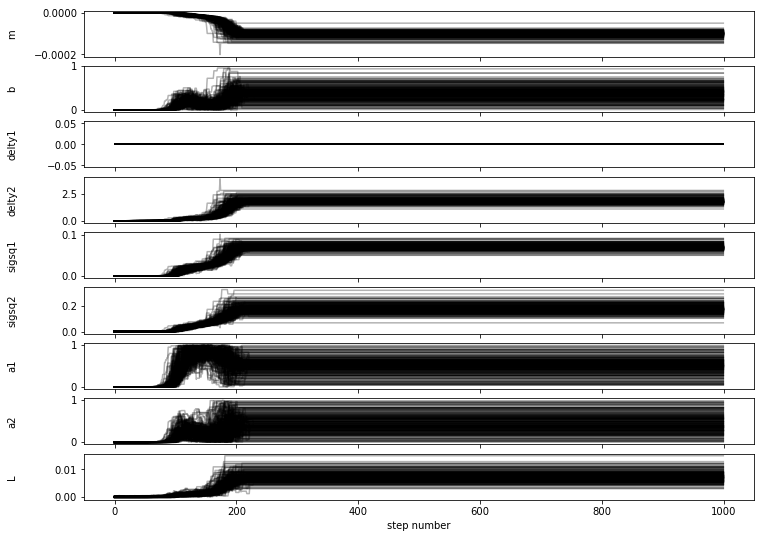

In [61]:
plt.figure(1)
fig, axes = plt.subplots(ndim, figsize=(12, 9), sharex=True)
samples = sampler.chain
labels = ["m", "b", "delty1", "delty2", "sigsq1", "sigsq2", "a1", "a2", "L"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
fig.savefig("plots_results/mcmc_fakedata.png")
plt.show()

In [62]:
flat_samples = sampler.chain[:, 400:, :].reshape((-1, ndim))

In [63]:
m_true = 0.0
b_true = .6

delty1_true = 0.0
delty2_true = 0.3
sigsq1_true = .01
sigsq2_true = .04
a1_true = .5
a2_true = .5
L_true = 1.0

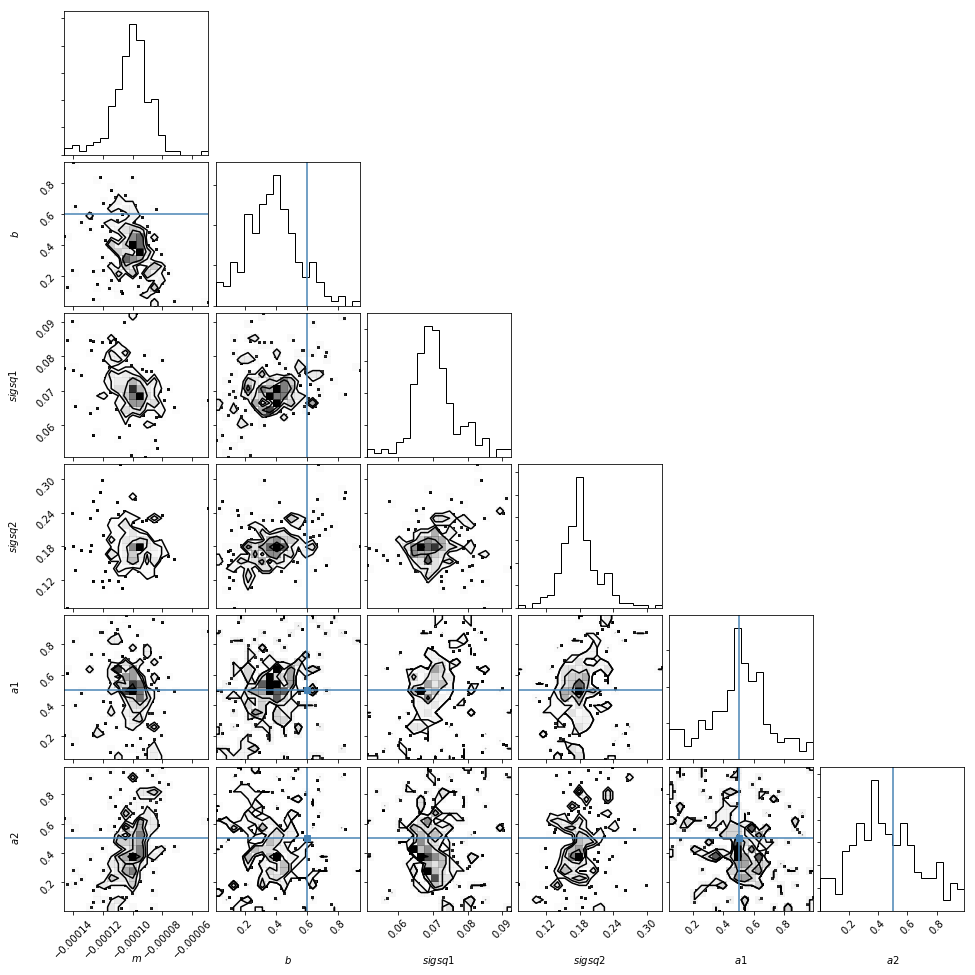

In [64]:
fig = corner.corner(flat_samples[:,[0,1,4,5,6,7]], labels=["$m$", "$b$", "$sigsq1$", "$sigsq2$", "$a1$", "$a2$"],
                      truths=[m_true, b_true, sigsq1_true, sigsq2_true, a1_true, a2_true])
fig.savefig("plots_results/mcmc_fakedata.png")

In [65]:
from IPython.display import display, Math
results = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    results.append(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>